# Seurat notes

These are my notes from some of the introductory vignettes provided for the Seurat package. These tutorial instruct how to analyse data from cellranger from QC to clustering/DE analysis. They use a publically available dataset of 2700 Peripheral Blood Mononuclear Cells (PBMC) from 10X Genomics. The vignettes can be found here:

https://satijalab.org/seurat/articles/get_started.html

In [69]:
library(repr)
options(repr.plot.width = 12, repr.plot.height = 8)

suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(Seurat))
suppressMessages(library(patchwork))

## Make Seurat Object

First, we need to load the PBMC dataset. The `Read10X` function reads output of cellranger pipeline, returning a unique molecular identified (UMI) count matrix where the columns are cells and rows are molecules.

In [2]:
pbmc.data <- Read10X(data.dir = 'datasets/pbmc3k/hg19')

We then need to initialize the Seurat object with the raw (non-normalized data). This will contain the count matrix in as well as later analyses e.g. PCA and clustering. We do this with the `CreateSeuratObject` function which has these parameters:
- `counts` - data (unnormalised)
- `project` - name
- `min.cells` - include features detected in at least this many cells
- `min.features` - include cells with at least this many features

In [3]:
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)

## Pre-processing

### QC and selecting cells

First, we need to perform quality control on our data. Here are a few commonly used QC metrics:
- Number of unique genes detected in each cell (this is calculated when creating a Seurat object and is found in the object metadata)
    - Low-quality cells or empty droplets - very few genes
    - Cell doublets or multiplets - high gene counts
- Total number of molecules detected within a cell (correlates strongly with unique genes)
- Percentage of reads that map to the mitochondrial genome (all genes starting with 'MT-') which indicate low-quality / dying cells. Mitochondrial QC metrics can be calculated with the `PercentageFeatureSet()` function (calculates the percentage of counts originating from a set of features e.g. MT genes)

More about this here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4758103/

In [4]:
# The [[ operator can add columns to object metadata. This is a great place to stash QC stats
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

In [5]:
head(pbmc@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898


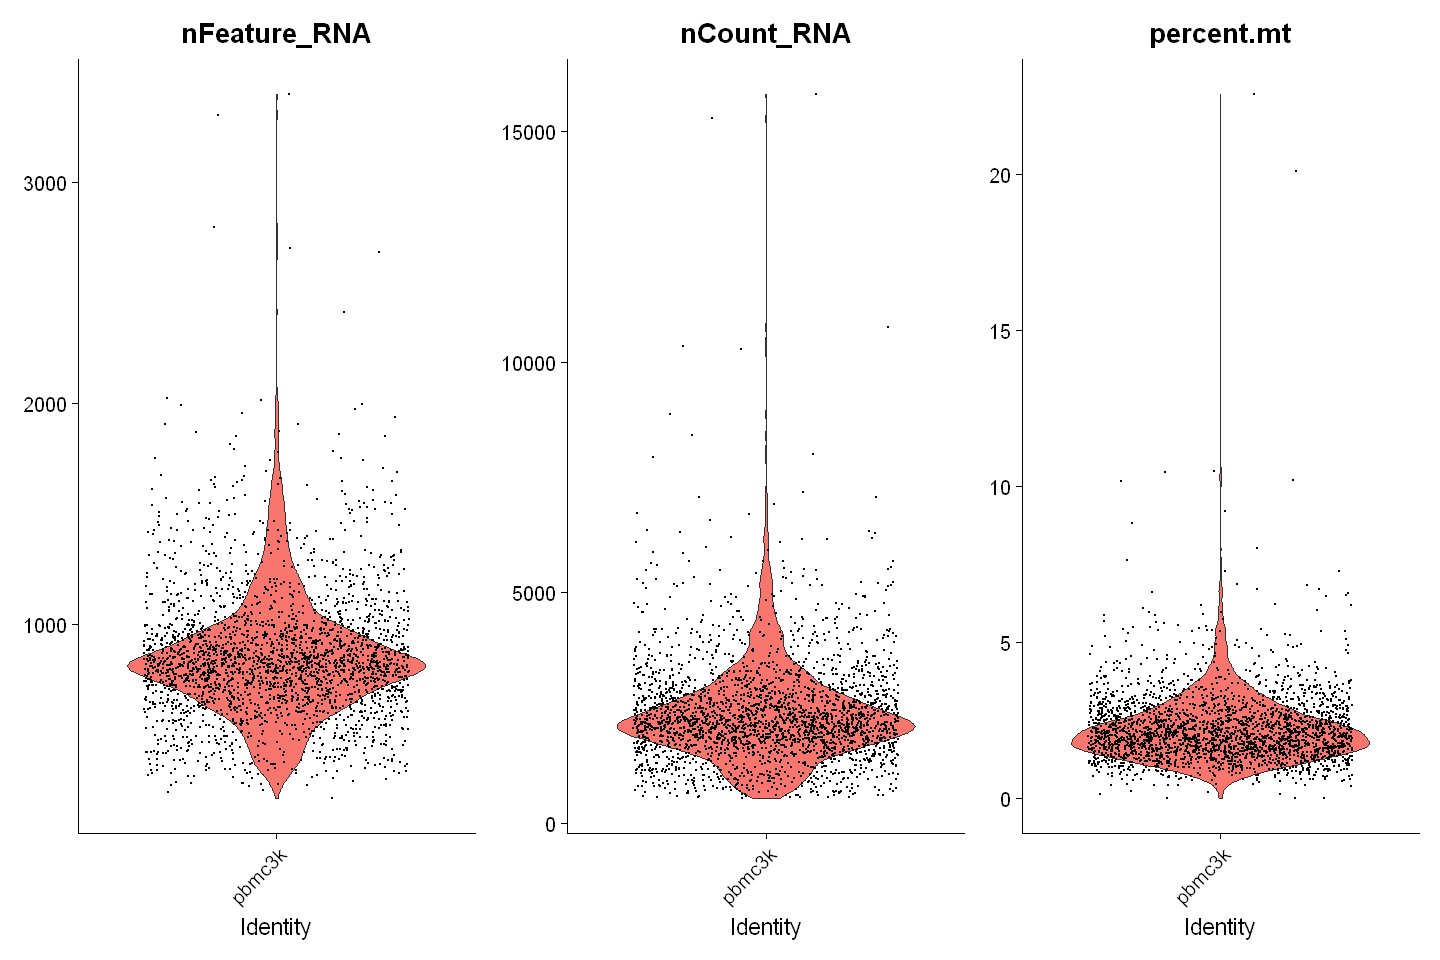

In [6]:
# We can visualise QC metrics as a violin plot
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

You can use `FeatureScatter` to visualize feature-feature relationships. It can be used for anything calculated by the object like columns in object metadata, PC scores etc.

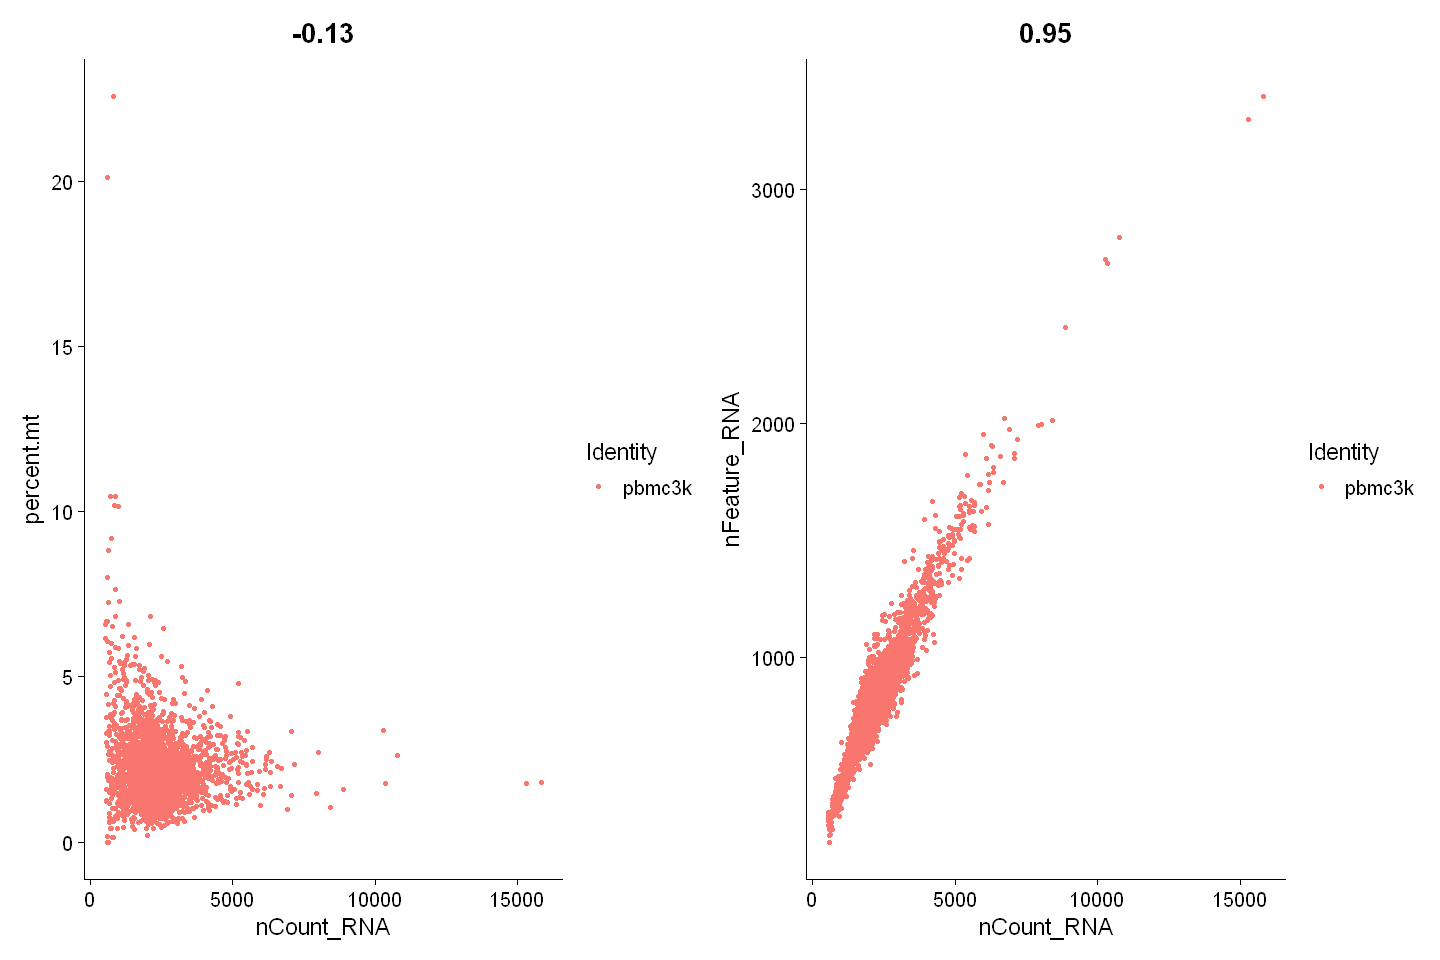

In [7]:
plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

**Filter cells**

We can then use our QC metrics to filter the cells. Lets filter ours:
- Unique feature counts over 2,500 or less than 200
- Over 5% mitochondrial count

In [8]:
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

### Normalising

Now we have removed the cells we don't want, we need to normalise the data. The default method for the `NormalizeData()` function is a global-scaling normalisation method 'LogNormalise' which:
1. Normalises feature expression measurements for each cell by the total expression
2. Multiplies this by a scale factor (10,000 by default) 
3. Log-transforms the result

In [9]:
pbmc <- NormalizeData(pbmc)

# These are some parameters:
# pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)

In [10]:
# The results are stored in the metadata

norm_value <- pbmc[["RNA"]]@data
norm_value[1:5, 1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
              AAACATACAACCAC-1 AAACATTGAGCTAC-1 AAACATTGATCAGC-1
AL627309.1                   .                .                .
AP006222.2                   .                .                .
RP11-206L10.2                .                .                .
RP11-206L10.9                .                .                .
LINC00115                    .                .                .
              AAACCGTGCTTCCG-1 AAACCGTGTATGCG-1
AL627309.1                   .                .
AP006222.2                   .                .
RP11-206L10.2                .                .
RP11-206L10.9                .                .
LINC00115                    .                .

### Feature Identification/Selection

scRNA-seq data can have thousands of genes. In order to analyse the data, we need to identify genes that are expressed highly in some cells and less in others (i.e. highly variable features). Seurat does this by directly modelling the mean-variance relationship inherent in single-cell data. To do this, use the `FindVariableFeatures()` function. This returns 2000 features per dataset by default. More on this here: 

https://linkinghub.elsevier.com/retrieve/pii/S0092867419305598

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 1 rows containing missing values (geom_point)."
Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 1 rows containing missing values (geom_point)."


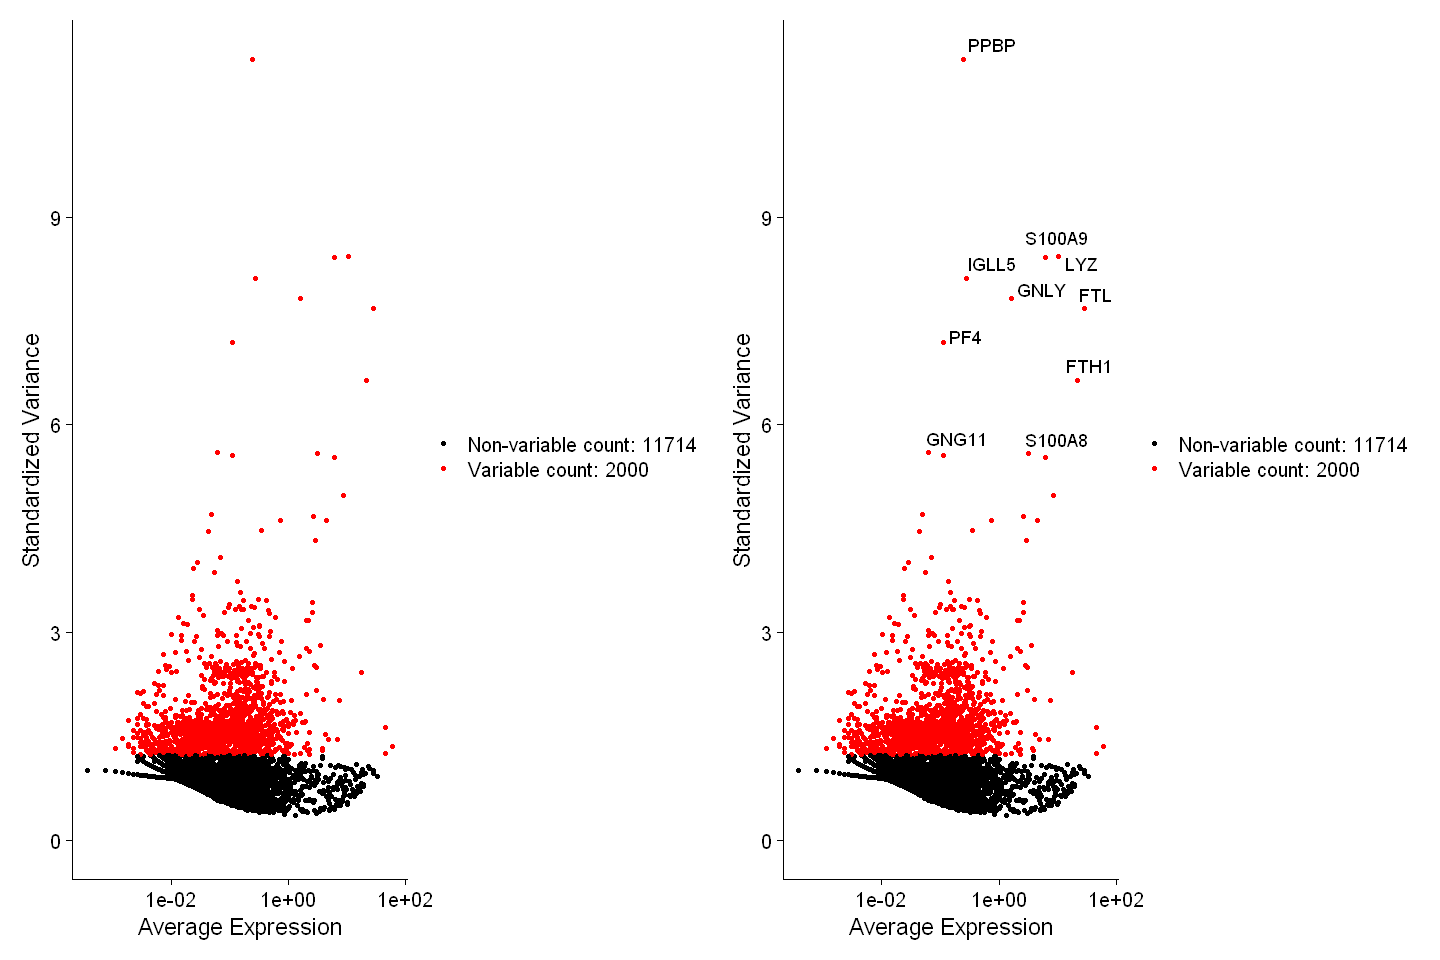

In [11]:
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(pbmc)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
options(repr.plot.width = 12)
plot1 + plot2

### Scaling

Next, we need to scale our data using the `ScaleData()` function. This is a linear transformation that is done before dimensional reduction that:
- Shifts the expression of each gene so that the mean expression across cells is 0
- Scales the expression of eah gene so that the variance across cells is 1 - this gives equal weight to highly expressed genes do not dominate downstream analyses

In [12]:
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

Centering and scaling data matrix



In [13]:
# Results are stored in the metadata

scaled_values <- pbmc[["RNA"]]@scale.data
scaled_values[1:5, 1:5]

,AAACATACAACCAC-1,AAACATTGAGCTAC-1,AAACATTGATCAGC-1,AAACCGTGCTTCCG-1,AAACCGTGTATGCG-1
AL627309.1,-0.05812316,-0.05812316,-0.05812316,-0.05812316,-0.05812316
AP006222.2,-0.03357571,-0.03357571,-0.03357571,-0.03357571,-0.03357571
RP11-206L10.2,-0.04166819,-0.04166819,-0.04166819,-0.04166819,-0.04166819
RP11-206L10.9,-0.03364562,-0.03364562,-0.03364562,-0.03364562,-0.03364562
LINC00115,-0.08223981,-0.08223981,-0.08223981,-0.08223981,-0.08223981


This also has a parameter, `vars.to.regress`, which lets you remove other sources of noise like cell cycle stage or mitochondirual contamination.

In [14]:
pbmc <- ScaleData(pbmc, vars.to.regress = "percent.mt")

Regressing out percent.mt

Centering and scaling data matrix



This can also be done using the `SCTransform()` function. A different tutorial covers this.

## Dimentional reduction

### Linear (PCA)

Now we need to reduce the dimentionality of the data. By default, only the 2000 variable features we identified are used as an input, but can be changed using `features` argument if the `RunPCA()` function.

In [15]:
pbmc <- suppressMessages(RunPCA(pbmc, features = VariableFeatures(object = pbmc)))

In [16]:
# The PCs are stored in the metadata
print(pbmc[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL 
Negative:  MALAT1, LTB, IL32, IL7R, CD2 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1 
Negative:  NKG7, PRF1, CST7, GZMA, GZMB 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPA1 
Negative:  PPBP, PF4, SDPR, SPARC, GNG11 
PC_ 4 
Positive:  HLA-DQA1, CD79B, CD79A, MS4A1, HLA-DQB1 
Negative:  VIM, IL7R, S100A6, S100A8, IL32 
PC_ 5 
Positive:  GZMB, FGFBP2, S100A8, NKG7, GNLY 
Negative:  LTB, IL7R, CKB, MS4A7, RP11-290F20.3 


We can visualise the top genes associated with reduction components using the `VizDimLoadings()` function.

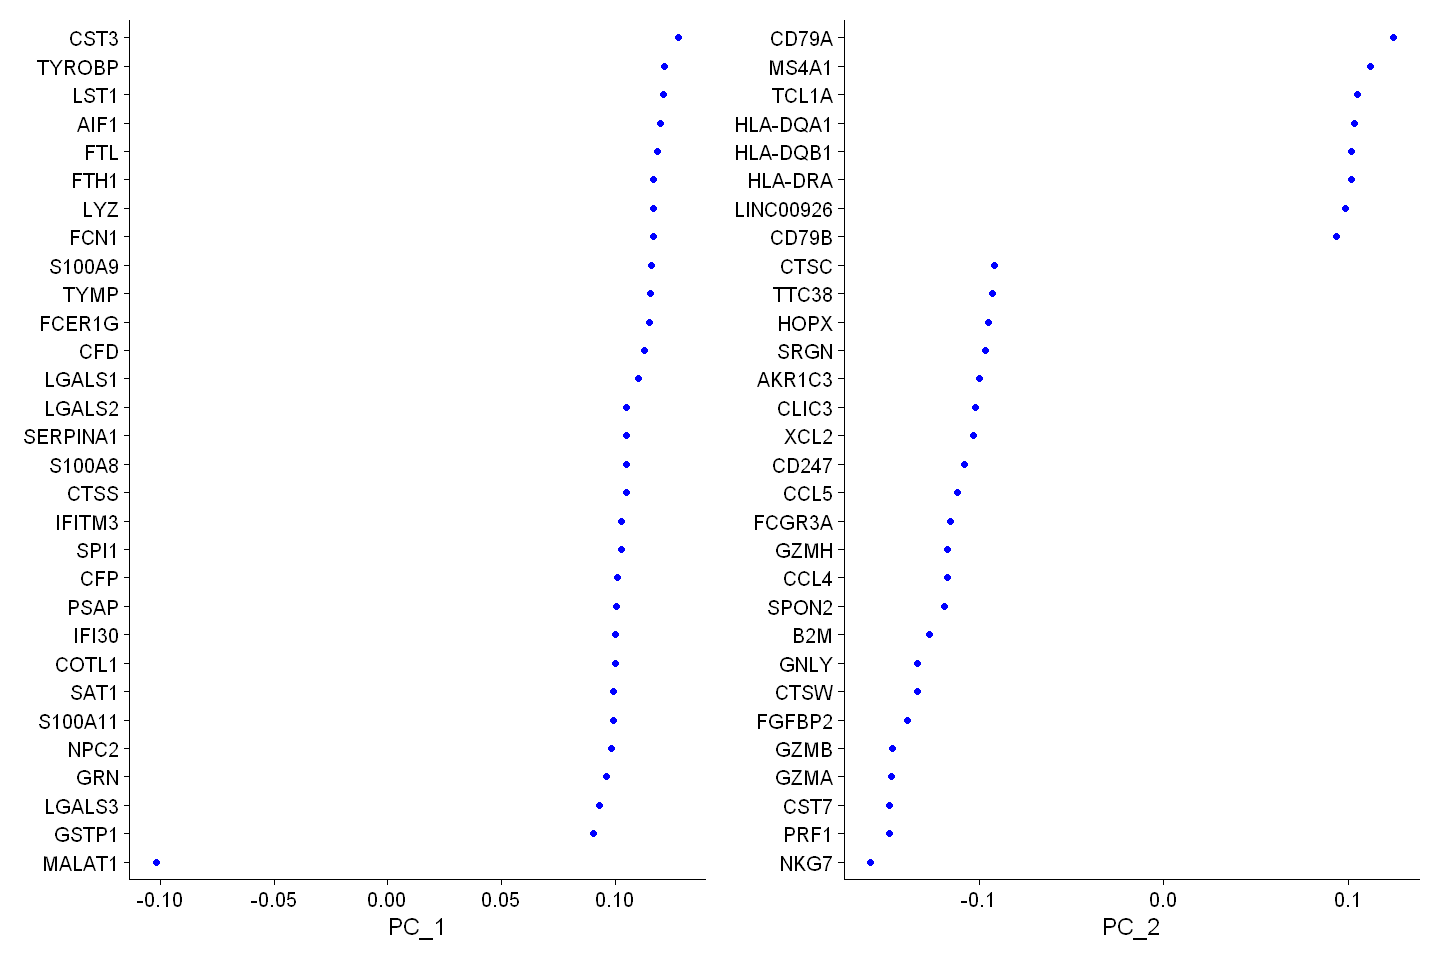

In [17]:
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")

We can ise the `DimPlot()` function to view out PCA plot.

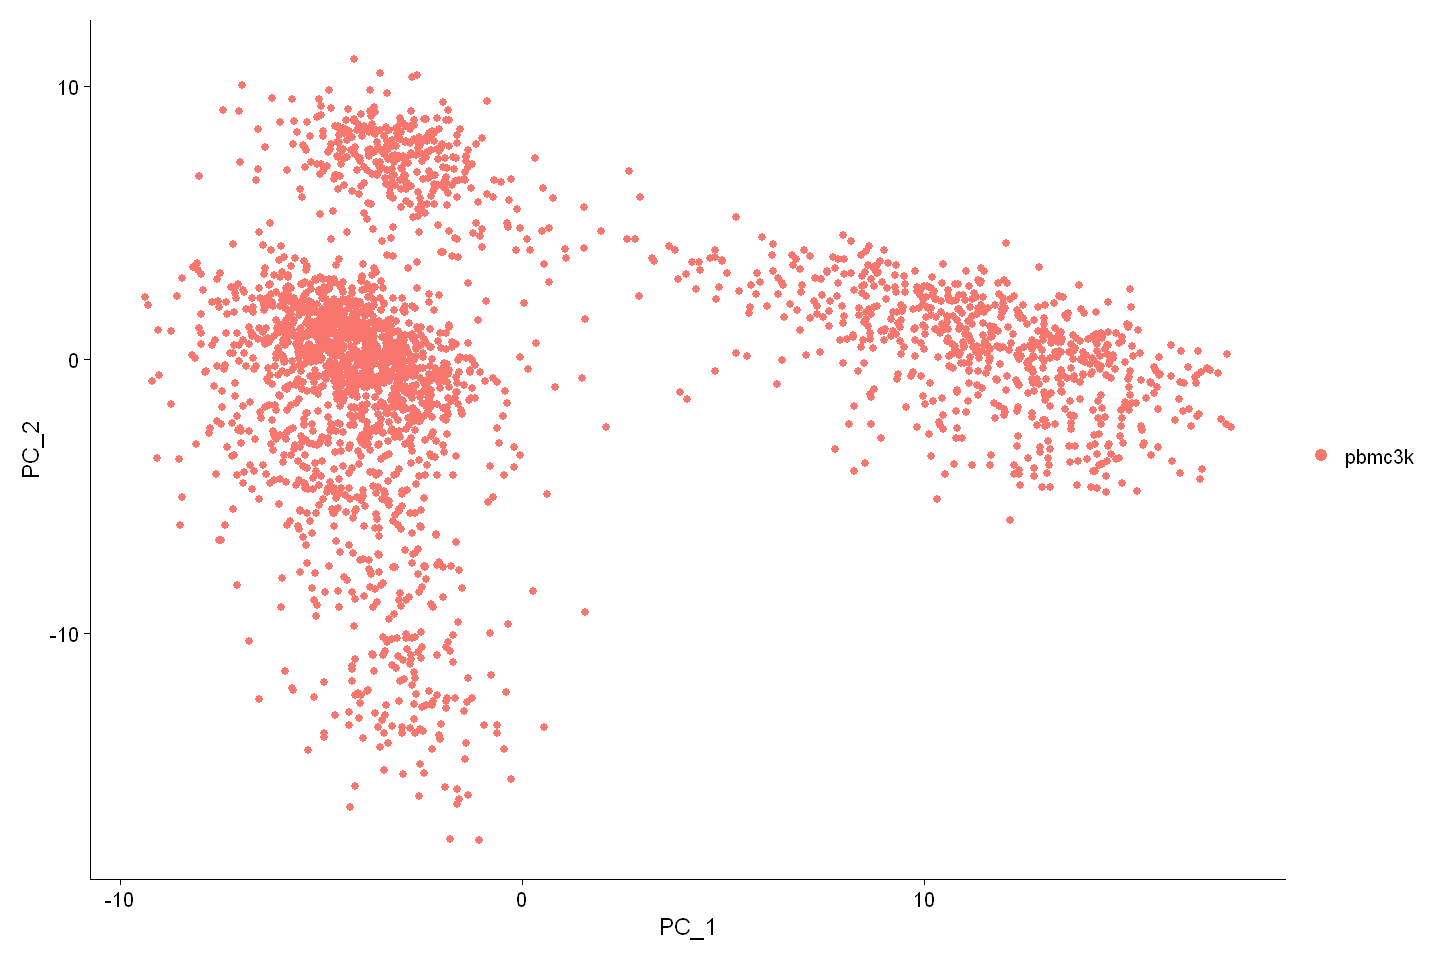

In [18]:
DimPlot(pbmc, reduction = "pca", pt.size = 2)

Plotting a heatmap, using the `DimHeatmap()` function, can be used to identify primary sources of heterogeneity in a dataset. This is useful for deciding which PCs to include for downstream analyses. Both the cells and features are ordered by their PCA scores. For large datasets, you can set the `cells` parameter to a number to include the most extreme cells on both ends of the spectrum.

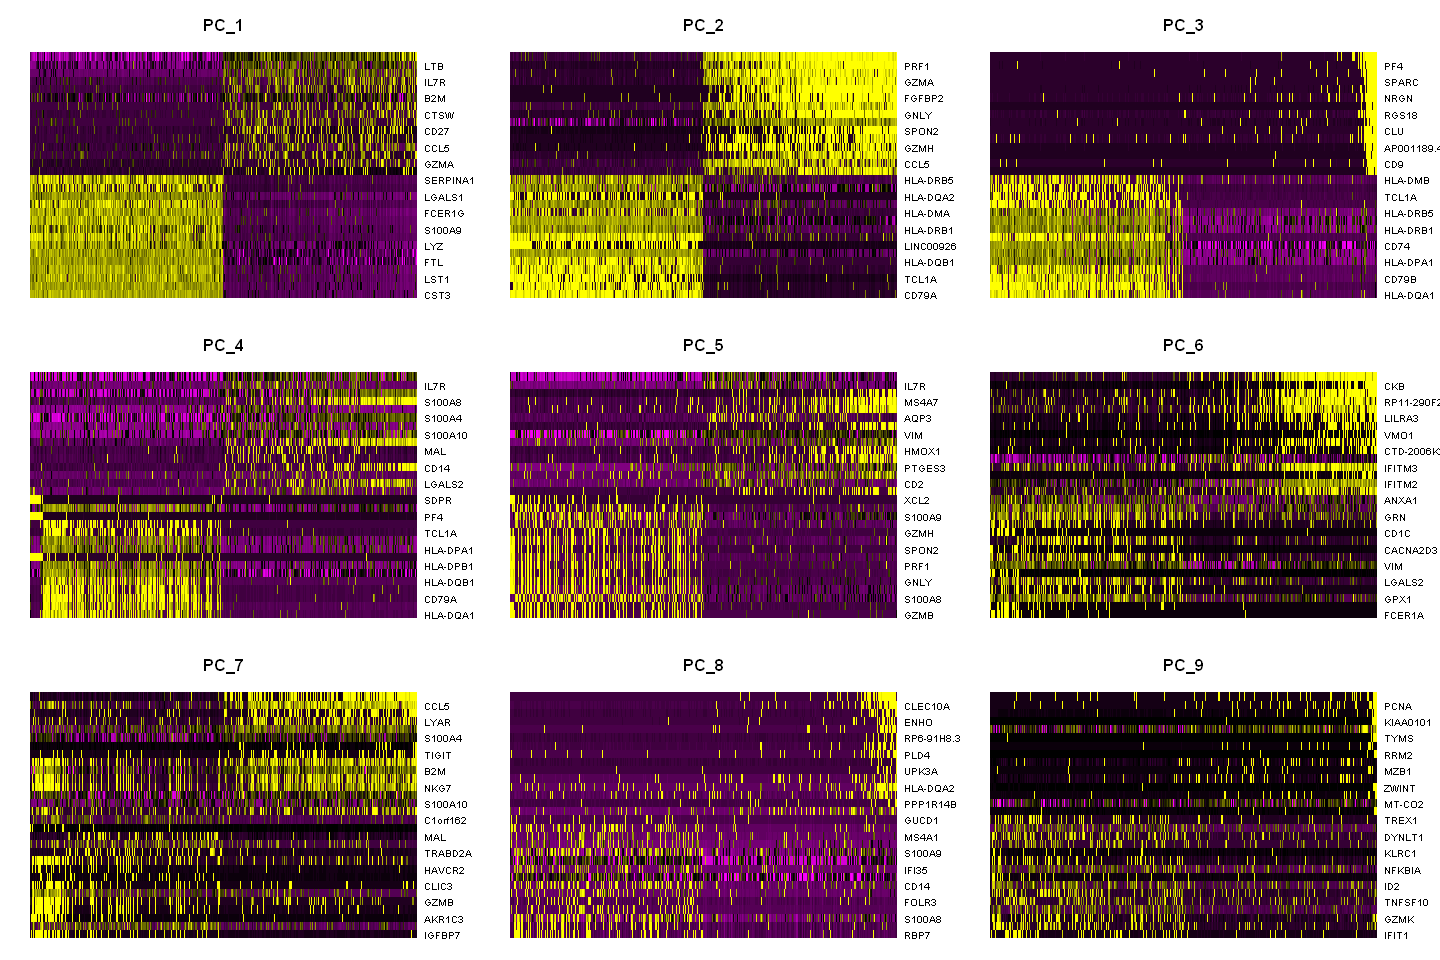

In [19]:
DimHeatmap(pbmc, dims = 1:9, cells = 500, balanced = TRUE)
options(repr.plot.height = 20)

#### Determining dimentionality

Seurat clusters cells based on their PCA scores, but we need to know how many PCs to choose. This can be done using the `JackStraw()` function. It selects 1% of the data at random, then runs a PCA. This is repeated to construct a 'null distributiuon' of feature scores. It then uses this to identify significant PCs that have many low p-value features.

In [20]:
pbmc <- JackStraw(pbmc, num.replicate = 100)
pbmc <- ScoreJackStraw(pbmc, dims = 1:20)

We can then visualise distribution of p-values for each PC using the `JackStrawPlot()` function which plots the distribution of p-values for each PC. Significant PCs will have a curve above the line.

Warning message:
"Removed 23438 rows containing missing values (geom_point)."


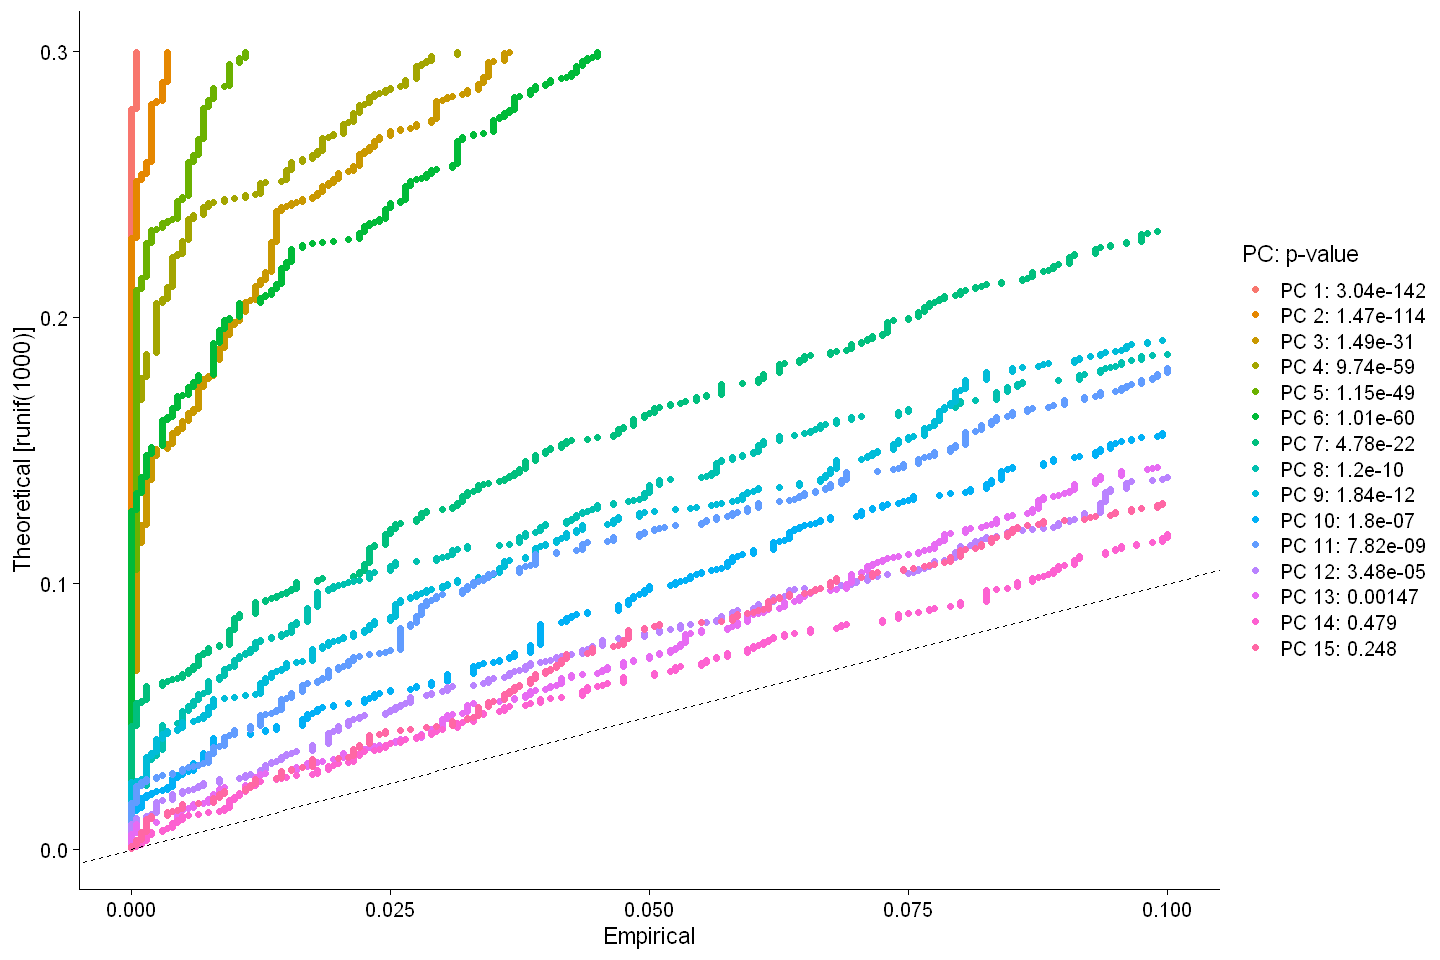

In [21]:
options(repr.plot.width = 12, repr.plot.height = 8)

JackStrawPlot(pbmc, dims = 1:15)

# You can see a drop-off in significance after the first 10-12 PCs.

As this can take a long time, the `ElbowPlot()` function can be used instead. This ranks principle components based on the percentage of variance explained by each one.

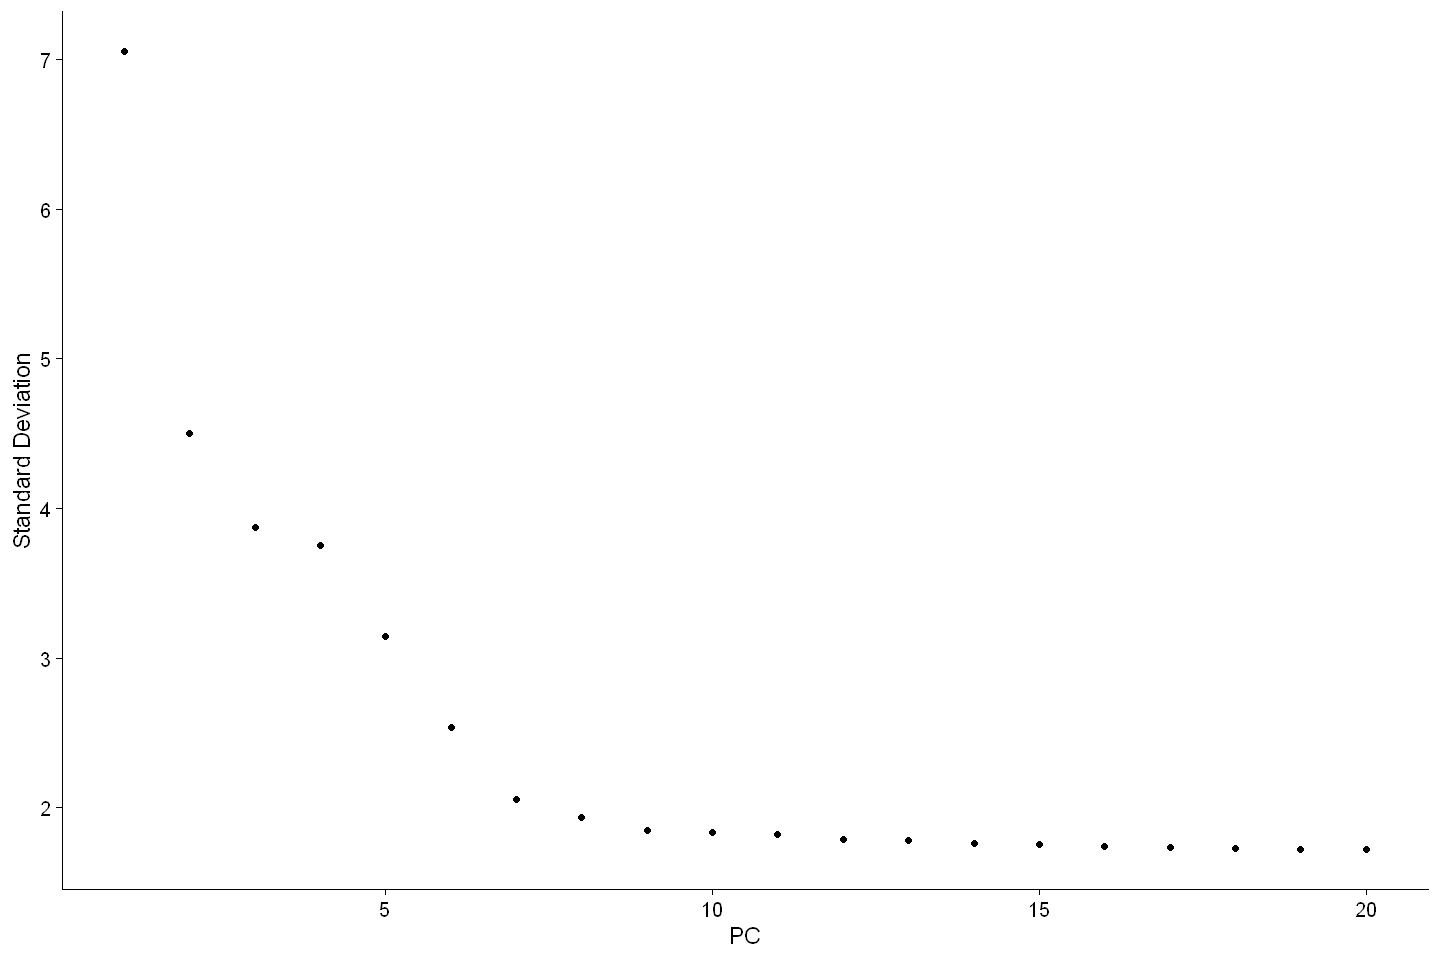

In [22]:
ElbowPlot(pbmc)

# This shows the majority of the variation is explained by the first 10 PCs

Before committing to a number of PCs, repeat downstream analyses using different numbers of PCs and err on the side of more.

## Clustering

Now we can start doing some biological analysis of the data. Seurat uses a graph-based clustering method where the cells are represented in a k-nearest neighbour graph based on the euclidean distance in PCA space. Edges are drawn between cells with similar gene expression patterns. The edge weights are refined based on the shared overlaps in their local neibourhoods (Jaccard similarity). This step is done using the `FindNeighbors()` function using the number of PCs identified in the previous step. 

The cells are then partitioned into highly interconnected 'communities'. This is done by applying modularity optimisation techniques, like the Louvain algorithm (default) or SLM, to iteratively group cells together with the aim of optimising the modulaity function. The `FindClusters()` function is used for this and has a `resolution` parameter that sets the 
'granulatiy' of downstream clustering. A higher resolution will give you more clusters. Larger datasets will need a larger resolution.

In [23]:
# dims is set to 1:10 as this is the number of PCs we identified in the last step
pbmc <- FindNeighbors(pbmc, dims = 1:10)

# Resolution for datasets ~3k cells usually require a resolution of 0.4 - 1.2
pbmc <- FindClusters(pbmc, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 96188

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8733
Number of communities: 9
Elapsed time: 0 seconds


In [24]:
# We can look at the clusters using the Idents() function
head(Idents(pbmc), 5)

AAACATACAACCAC-1 AAACATTGAGCTAC-1 AAACATTGATCAGC-1 AAACCGTGCTTCCG-1 
               0                3                2                1 
AAACCGTGTATGCG-1 
               6 
Levels: 0 1 2 3 4 5 6 7 8

## Non-linear dimentional reduction (UMAP/tSNE)

Now lets visualise our clusters. We can do this using non-linear dimensional rediction techniques. Seurat includes several of these like UMAP and t-SNE. These algorithms try to learn the underlying manifold of the data in order to place similar cells together in low-dimentional space. When we group cells within graph-based clusters, like we did above, the clusters should co-localise on these dimention reduction plots. UMAP is done using the `RunUMAP()` function using the same PCs as in the clustering analysis.

In [25]:
pbmc <- suppressMessages(RunUMAP(pbmc, dims = 1:10))

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"


The `DimPlot()` function plot either UMAP, t-SNE or PCA by default (in that order).
- `label` - set to `TRUE` to label clusters (or use `labelClusters()` function).

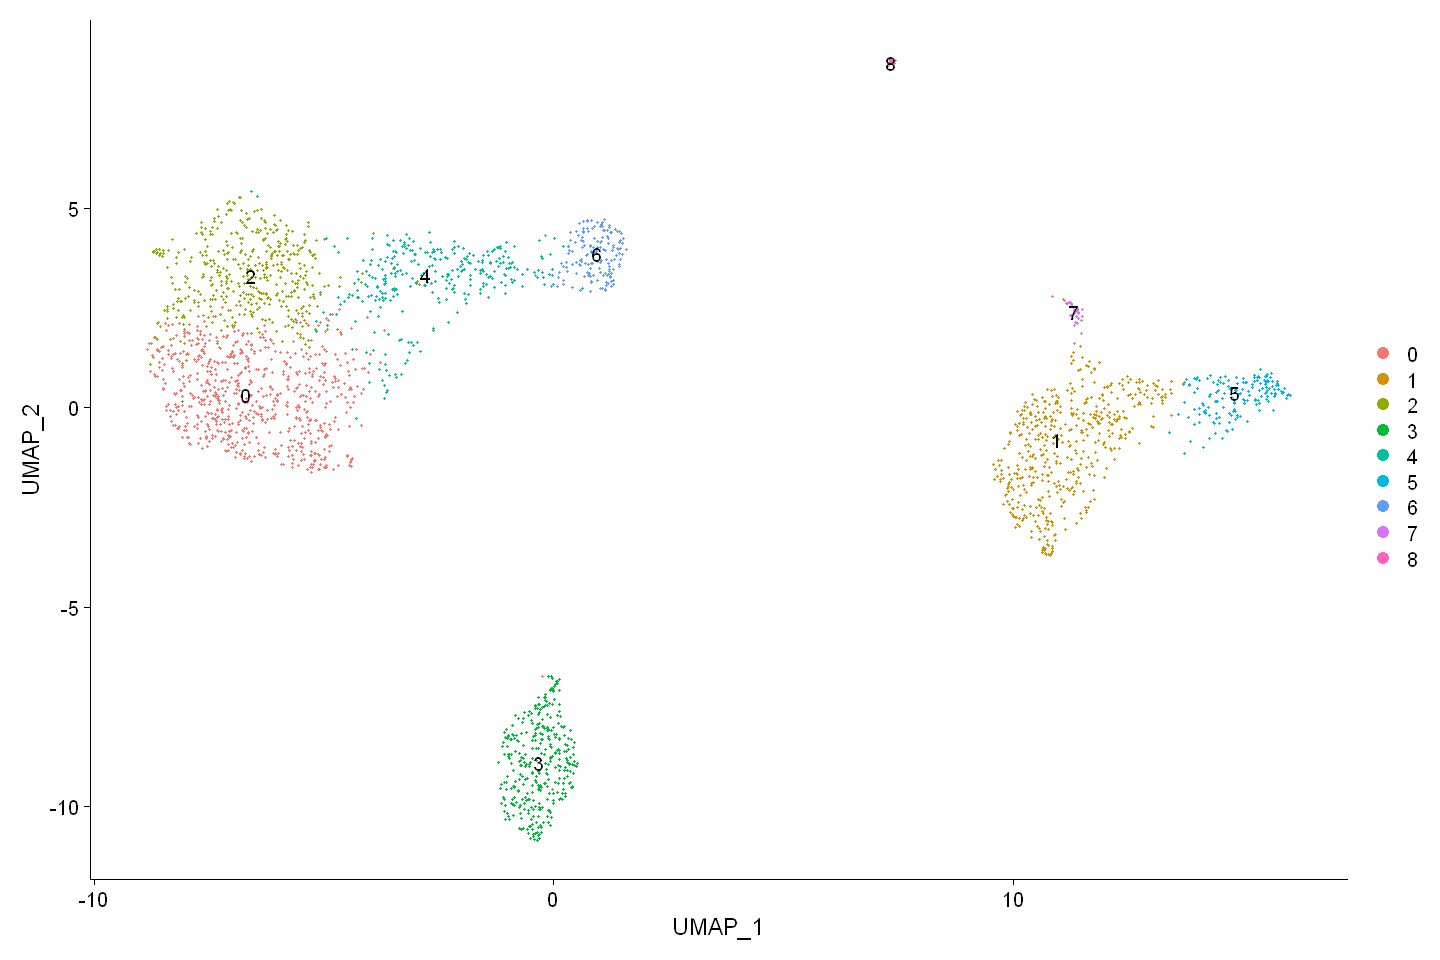

In [26]:
DimPlot(pbmc, reduction = "umap", label = TRUE)

## Differential expression

Now we have our clusters, its time to find out what cells they are. We can do this by identifying markers for each cluster using the `FindAllMarkers()` function which compares the expression of genes in cell is a cluster will all other cells. This identifies both positive and negative markers. Here are some of the parameters for this function:
- `ident.1` - specify which cluster you would like to compare with the other cells
- `min.pct` - this is the minimum percentage a feature has to be detected in the two groups (cluster and all other cells)
- `thresh.test` - requires a feature to be differentially expressed (on average) by some amount between the two groups
- `max.cells.per.ident` - this will downsample each group (note, this will reduce the power)
- `min.diff.pct` - this will filter genes that have similar detection percentage

The last three points will speed up the analysis.

In [27]:
# Let's find the markers of cluster 2
cluster2.markers <- FindMarkers(pbmc, ident.1 = 2, min.pct = 0.25)
head(cluster2.markers, n = 5)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LTB,1.923910e-81,1.2699475,0.982,0.648,2.638451e-77
IL32,4.949890e-80,1.1155914,0.945,0.474,6.788279e-76
LDHB,2.051497e-66,0.9366430,0.968,0.616,2.813423e-62
CD3D,3.635745e-63,0.9219353,0.916,0.441,4.986061e-59
IL7R,1.187439e-60,1.1655544,0.745,0.334,1.628453e-56


These are the outputs for the `FindMarkers()` function:
- `avg_logFC` - The log fold-chage of the average expression between the two groups. Positive values indicate that the gene is more highly expressed in the first group
- `pct.1` - The percentage of cells where the gene is detected in the first group
- `pct.2` - The percentage of cells where the gene is detected in the second group
- `p_val_adj` - Adjusted p-value, based on bonferroni correction using all genes in the dataset

In [28]:
# find all markers distinguishing cluster 5 from clusters 0 and 3
cluster5.markers <- FindMarkers(pbmc, ident.1 = 5, ident.2 = c(0, 3), min.pct = 0.25)
head(cluster5.markers, n = 5)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FCGR3A,6.594528e-206,4.255823,0.975,0.041,9.043735e-202
IFITM3,2.879941e-198,3.883791,0.975,0.048,3.949551e-194
CFD,1.886391e-197,3.422712,0.938,0.036,2.586997e-193
CD68,1.023325e-192,3.012326,0.926,0.035,1.403388e-188
RP11-290F20.3,4.071992e-189,2.721726,0.840,0.016,5.584330e-185


In [38]:
# Now lets find markers for every cluster compared to all remaining cells
# report only the positive ones

pbmc.markers <- suppressMessages(FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25))
pbmc.markers %>%
    group_by(cluster) %>%
    slice_max(n = 2, order_by = avg_log2FC) %>%
    head()

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1.257343e-82,1.322516,0.435,0.110,1.724321e-78,0,CCR7
1.354189e-49,1.083814,0.340,0.106,1.857134e-45,0,PRKCQ-AS1
0.000000e+00,5.570063,0.996,0.215,0.000000e+00,1,S100A9
0.000000e+00,5.477394,0.975,0.121,0.000000e+00,1,S100A8
1.923910e-81,1.269947,0.982,0.648,2.638451e-77,2,LTB
1.267313e-55,1.237544,0.655,0.251,1.737992e-51,2,CD2


By default, Seurat uses a Wilcoxon rank sum test, but you can use the `test.use` argument dentotes which test to use:
- `wilcox` (default) - Wilcoxon rank sum test
- `bimod` - likelihood ratio test for single cell feature expression
- `roc` - Standard AUC classifier
- `t` - t test
- `poisson` - likelihood ratio test assuming an underlying negative binomial distribution (UMI only)
- `negbinom` - likelihood ratio test assuming an underlying negative binomial distribution (UMI only)
- `LR` - uses logistic regression model predicting group membership based on each feature individually then compares to a null model with a likelihood ratio test
- `MAST` - GLM-framework that treates cellular detection rate as a covariate (installation required)
- `DESeq2` - DE based on a model using the negative binomial distribution (installation required)

In [30]:
cluster0.markers <- FindMarkers(pbmc, ident.1 = 0, logfc.threshold = 0.25, test.use = "t", only.pos = TRUE)
head(cluster0.markers)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RPS12,5.211783e-180,0.7321297,1.000,0.991,7.147440e-176
RPS6,6.909707e-177,0.6885077,1.000,0.995,9.475972e-173
RPS27,3.886918e-176,0.7181105,0.999,0.992,5.330520e-172
RPS25,1.814231e-151,0.7745891,0.997,0.975,2.488036e-147
RPS14,9.337286e-151,0.6299283,1.000,0.994,1.280515e-146
RPL32,1.758858e-143,0.6272242,0.999,0.995,2.412098e-139


### Marker visualisation

In [63]:
pbmc$groups <- sample(c("group1", "group2"), size = ncol(pbmc), replace = TRUE)

**Violin plots**

We can use the `VlnPlot()` function to visualise the expression probability distributions across clusters.
- `split.by` - split on a variable

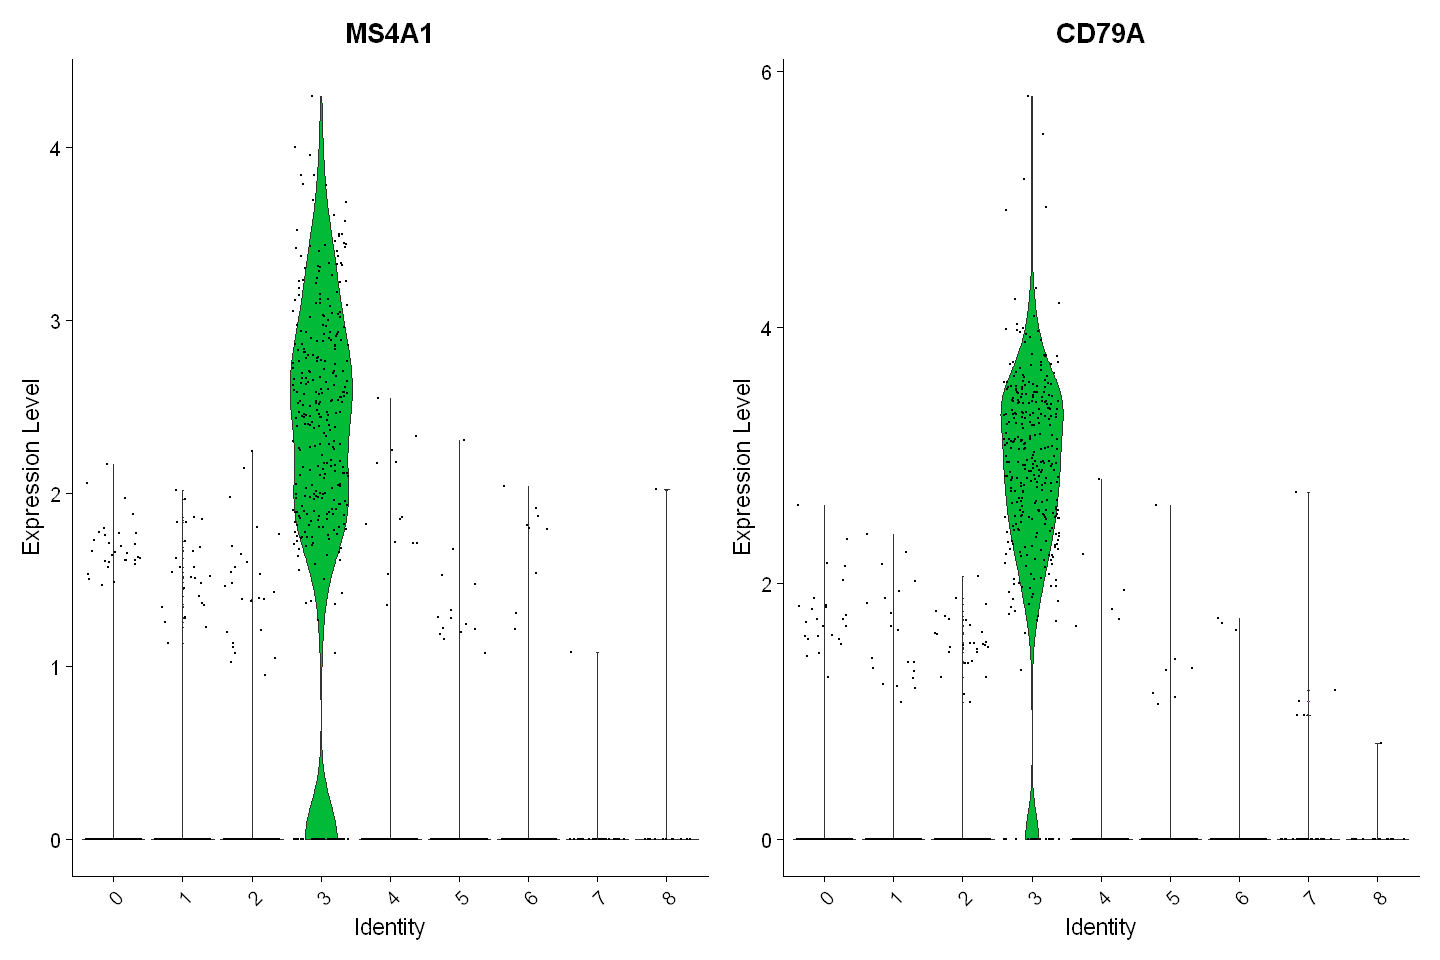

In [31]:
VlnPlot(pbmc, features = c("MS4A1", "CD79A"))

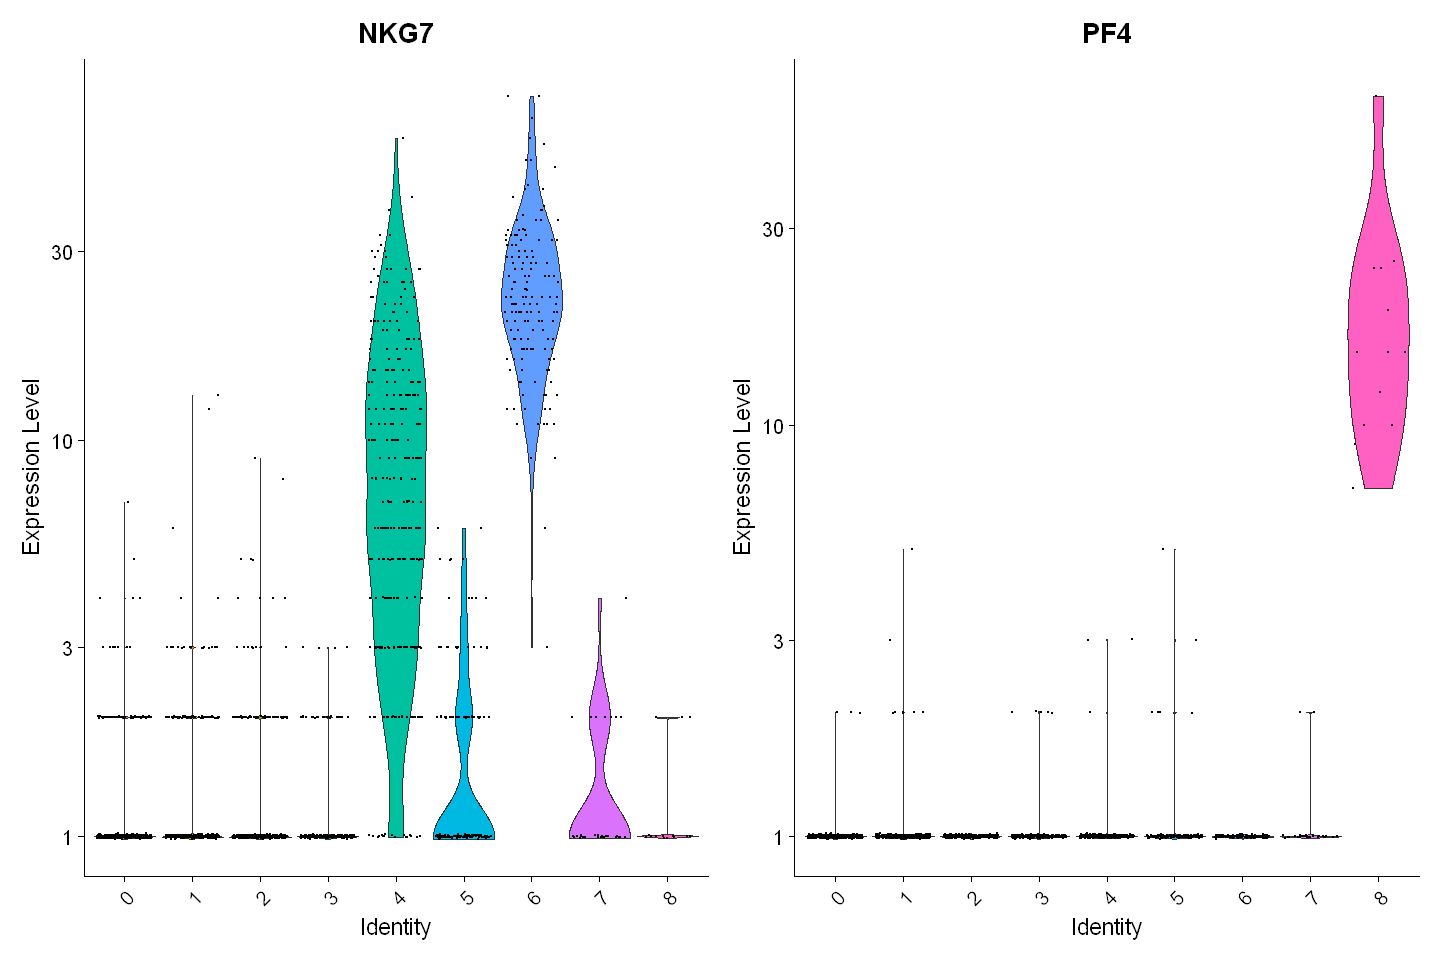

In [32]:
# you can plot raw counts as well
VlnPlot(pbmc, features = c("NKG7", "PF4"), slot = "counts", log = TRUE)

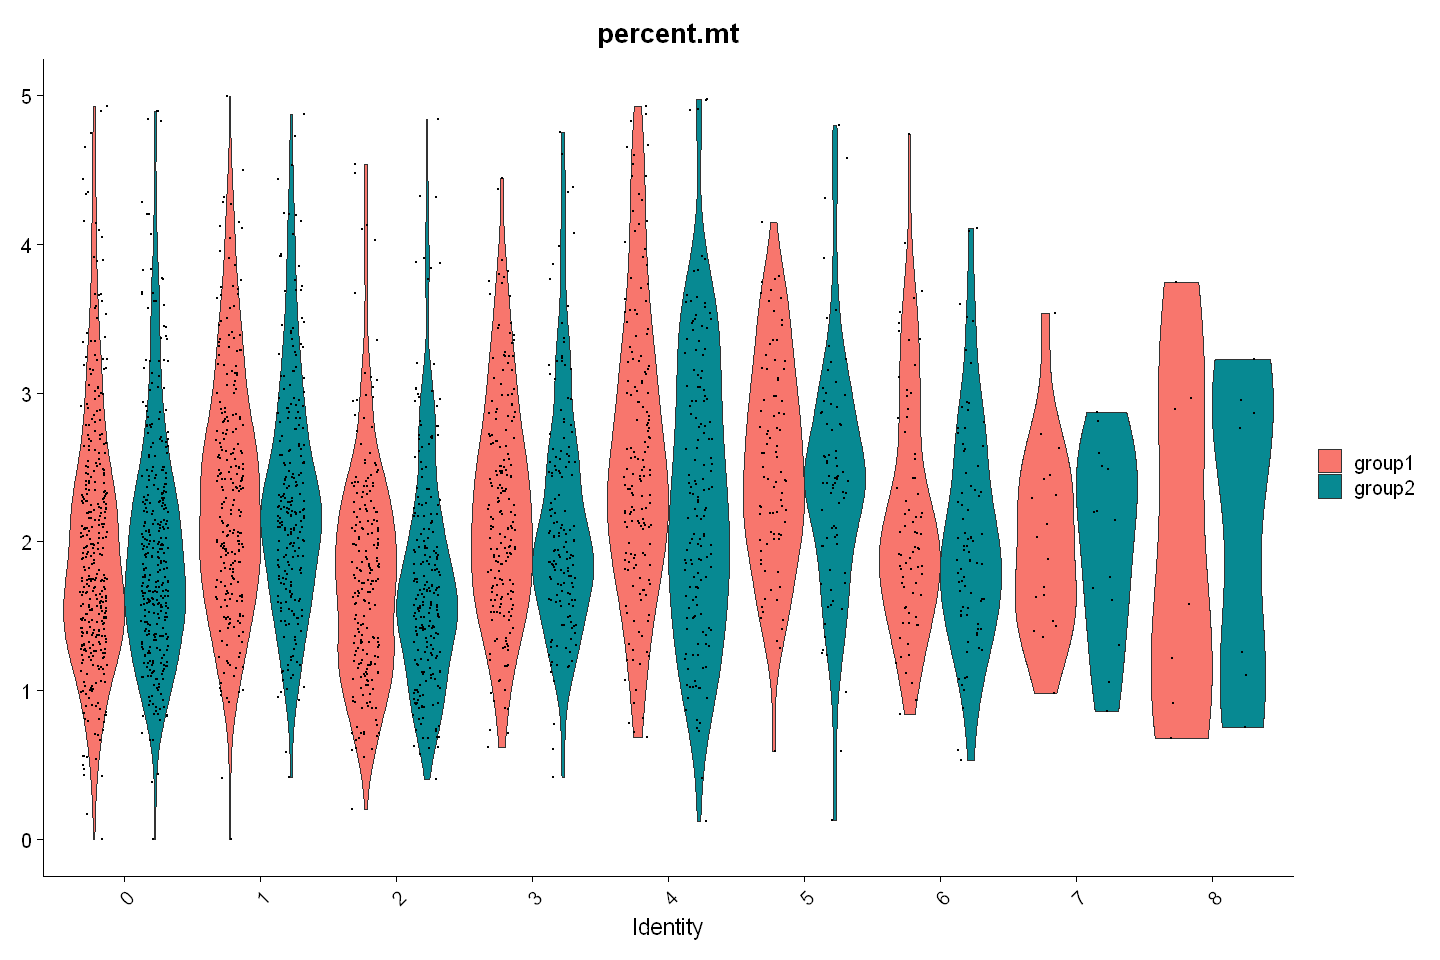

In [65]:
# Split your data into groups based on a variable

VlnPlot(pbmc, features = "percent.mt", split.by = "groups")

**Ridge plots**

Use the `RidgePlot()` function from `ggridges` to visualise gene expression distributions.

Picking joint bandwidth of 0.108

Picking joint bandwidth of 0.318



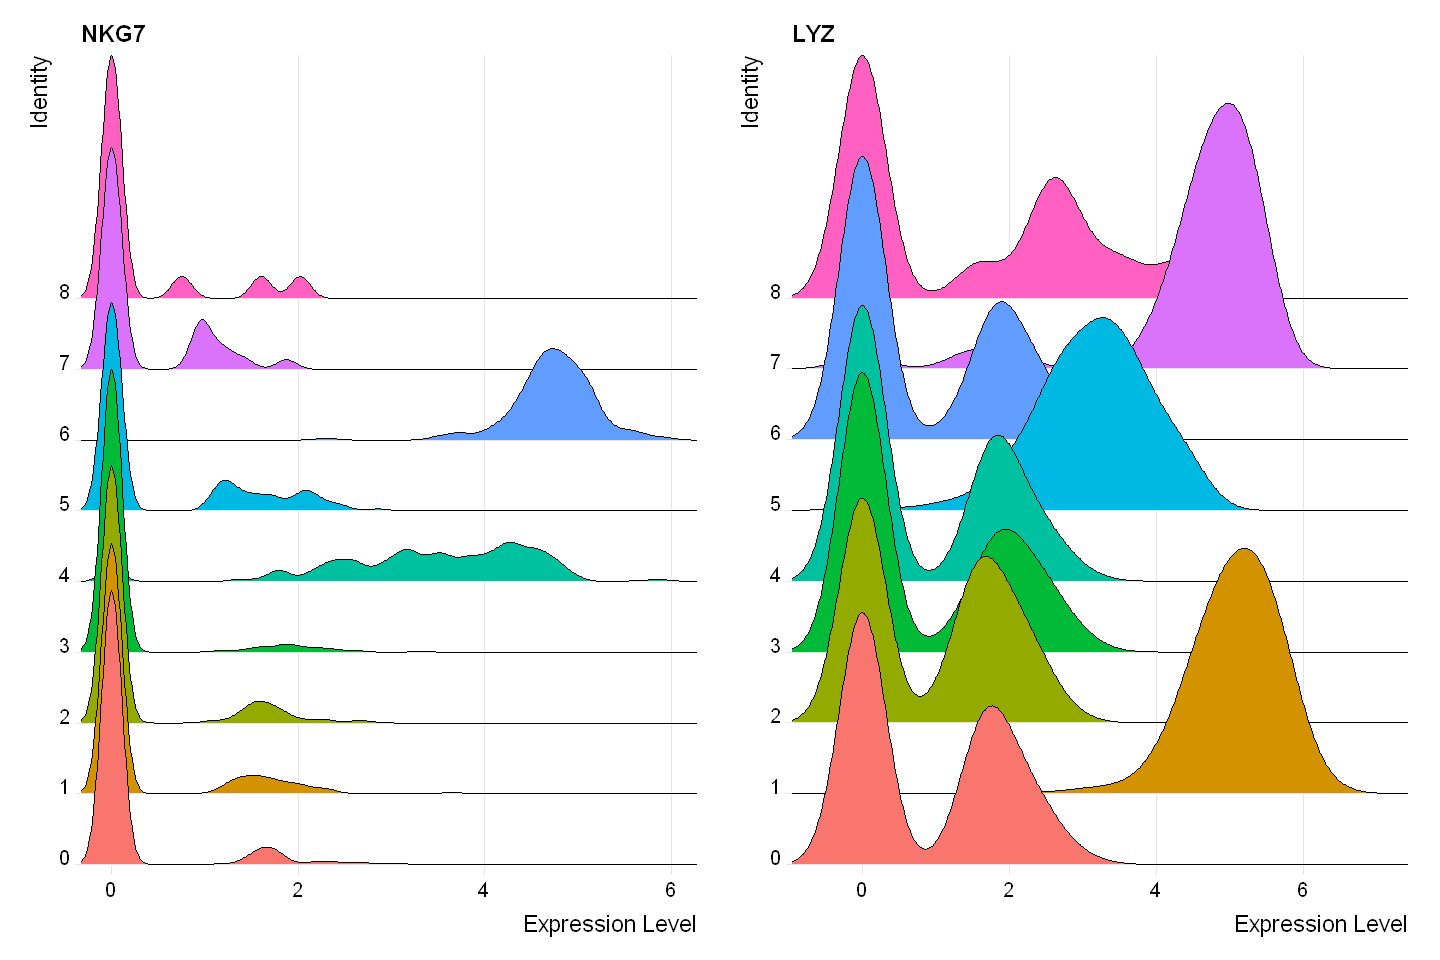

In [40]:
RidgePlot(pbmc, features = c("NKG7", "LYZ"), ncol = 2)

**Feature plots**

You can use `FeaturePlot()` to visualise gene expression on tSNE or PCA plot.
- `min.cutoff` and `max.cutoff` - adjusts the contrast of the plot. Calculated feature-specific contrast lelvels based on quantiles of non-zero expression (good for plotting multiple markers) e.g. `min.cutoff = 'q10'`.
- `blend` - set to `TRUE` to visualise two features at once
- `split.by` - split expression by group

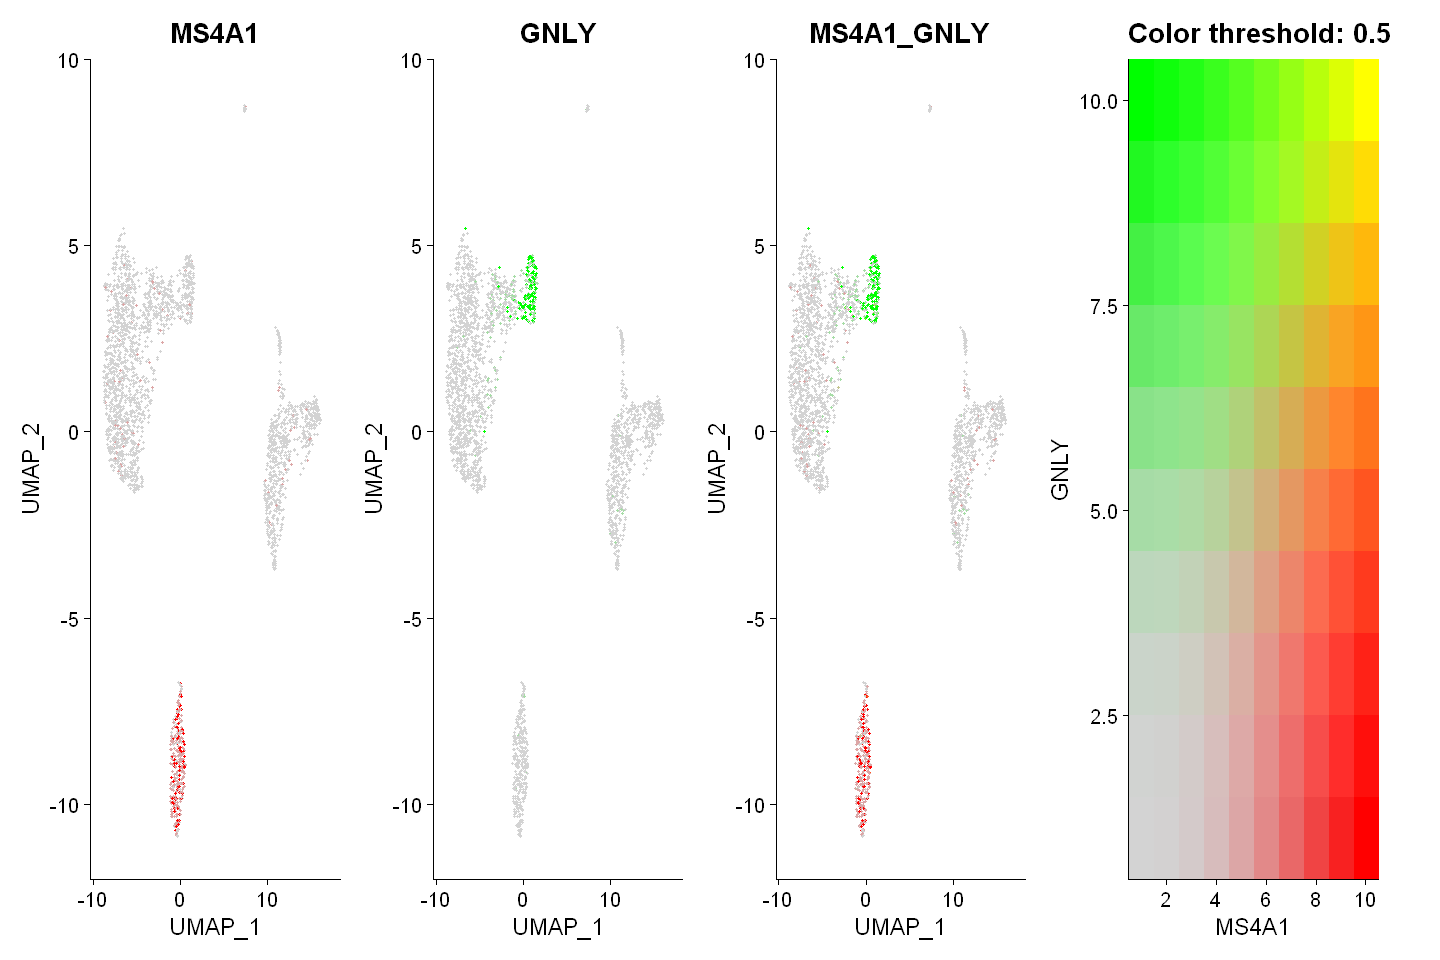

In [57]:
FeaturePlot(pbmc, features = c("MS4A1", "GNLY"), blend = TRUE)

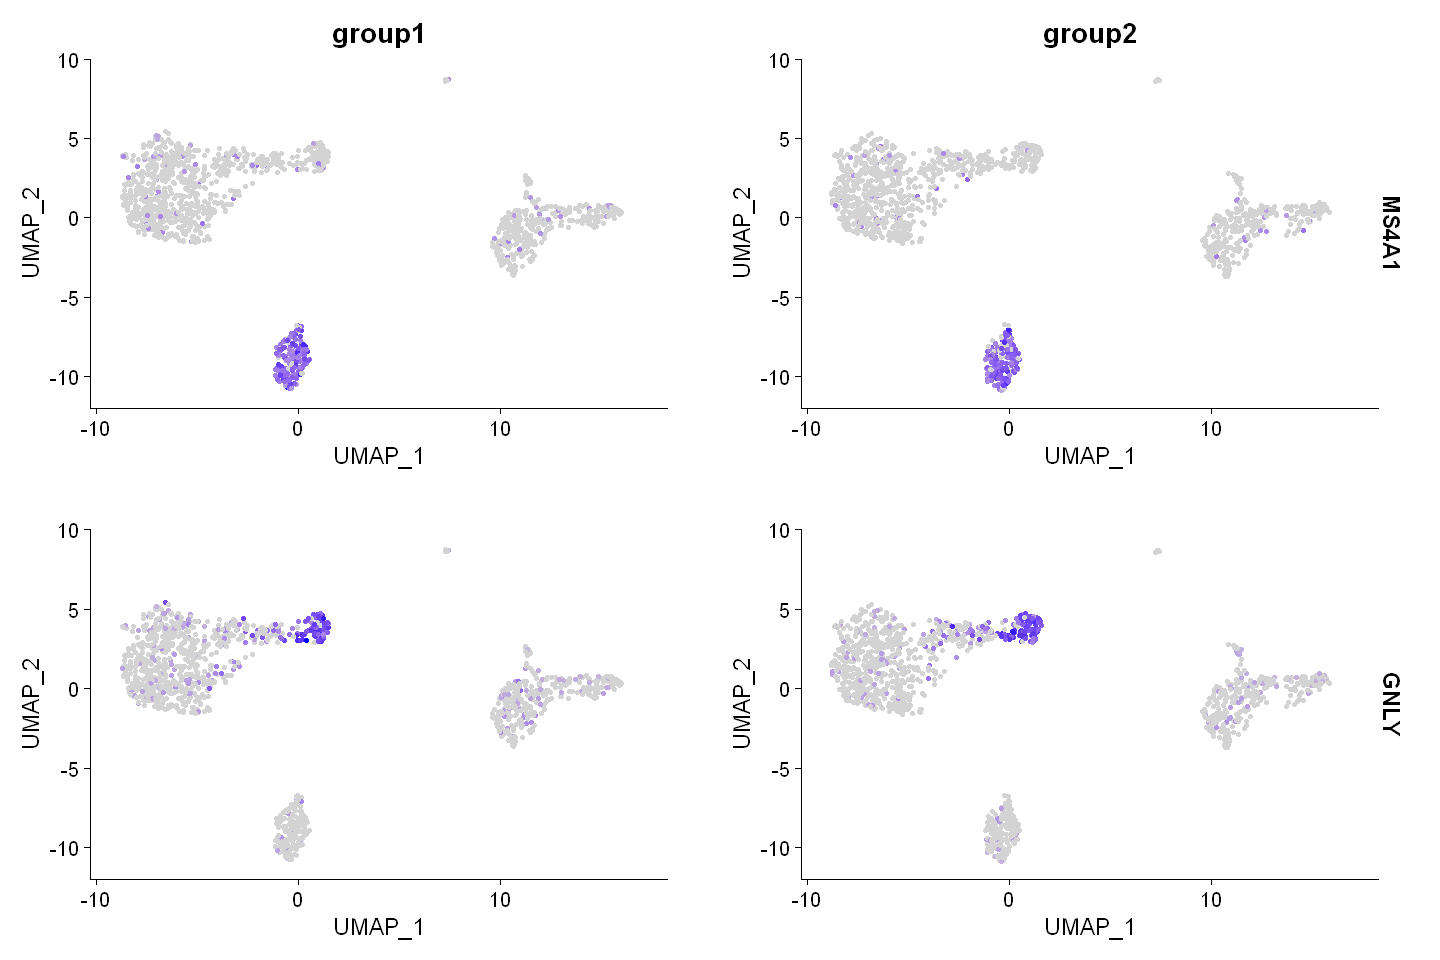

In [61]:
FeaturePlot(pbmc, features = c("MS4A1", "GNLY"), split.by = 'groups')

**Dot plots**

The `DotPlot()` function creates a plot where the size of the dot corresponds to the percentage of cells and the colour represents the average expression level.
- `split.by` - split into groups based on a variable

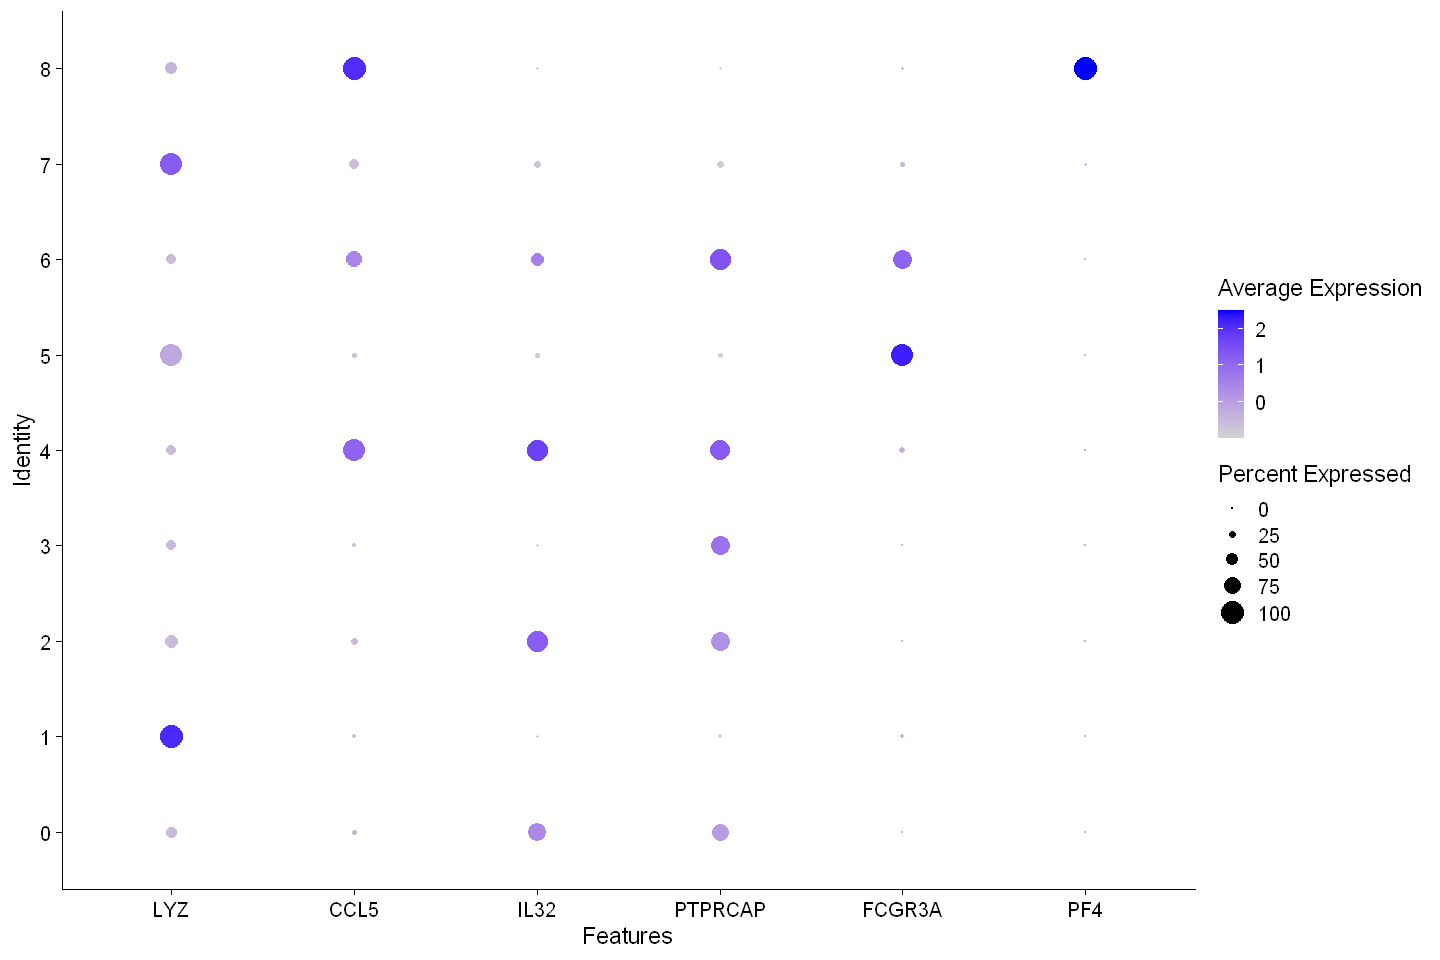

In [41]:
DotPlot(pbmc, features = c('LYZ', 'CCL5', 'IL32', 'PTPRCAP', 'FCGR3A', 'PF4'))

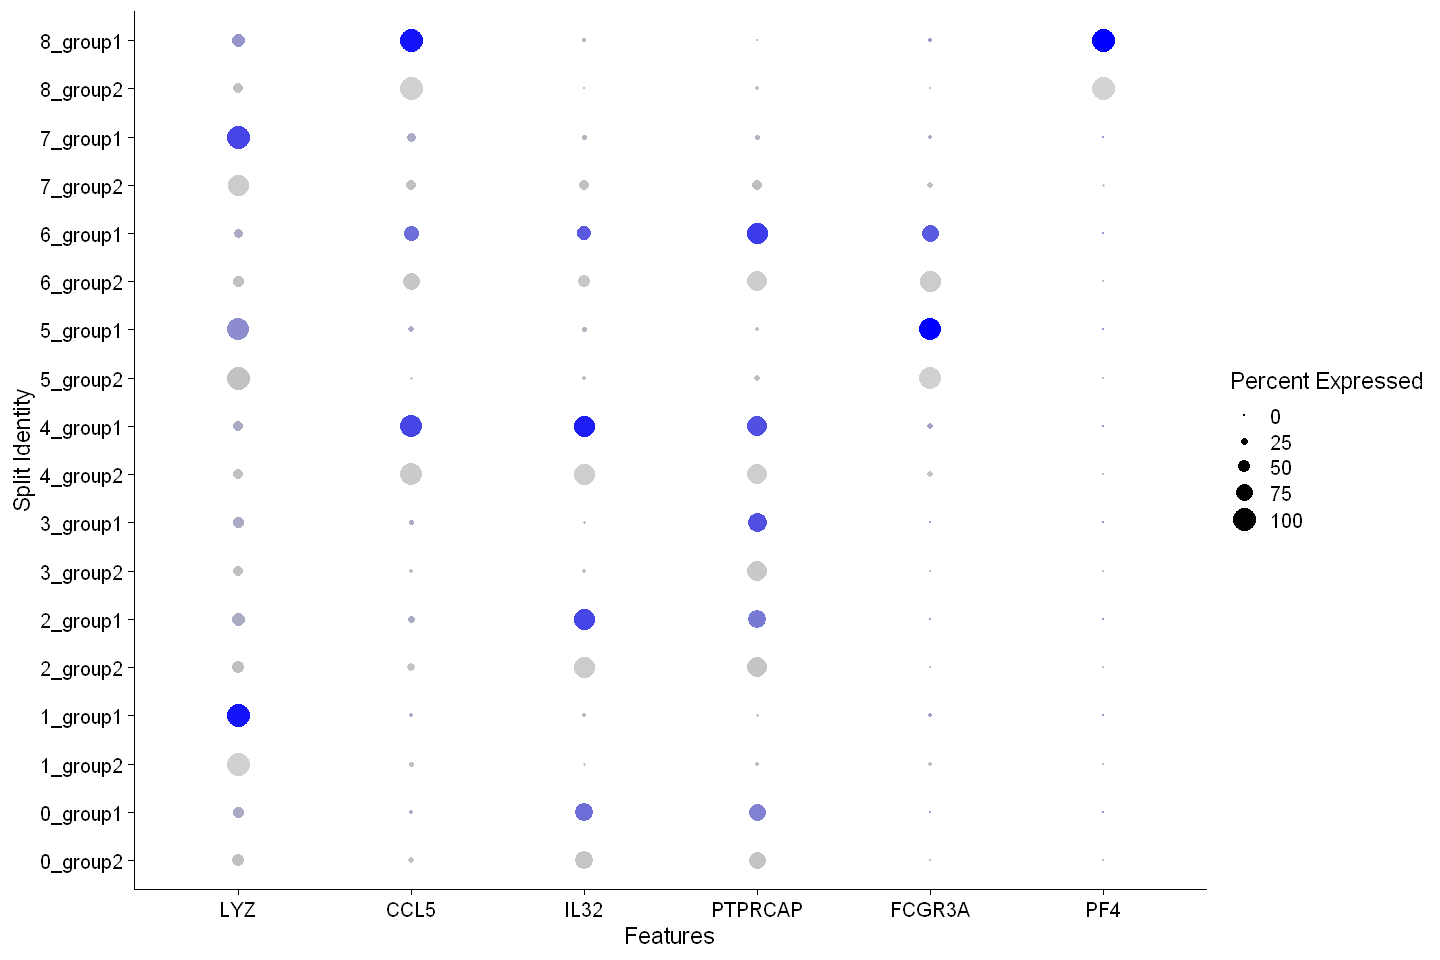

In [66]:
DotPlot(pbmc, features = c('LYZ', 'CCL5', 'IL32', 'PTPRCAP', 'FCGR3A', 'PF4'), split.by = "groups")

**Heatmaps**

You can also plot the expression of top markers for each cluster using `DoHeatmap()` .

Warning message in DoHeatmap(pbmc, features = top10$gene):
"The following features were omitted as they were not found in the scale.data slot for the RNA assay: CD8A, VPREB3, CD40LG, PIK3IP1, LEF1, NOSIP, PRKCQ-AS1, CD3E, CD3D, CCR7, RPS3A, LDHB"


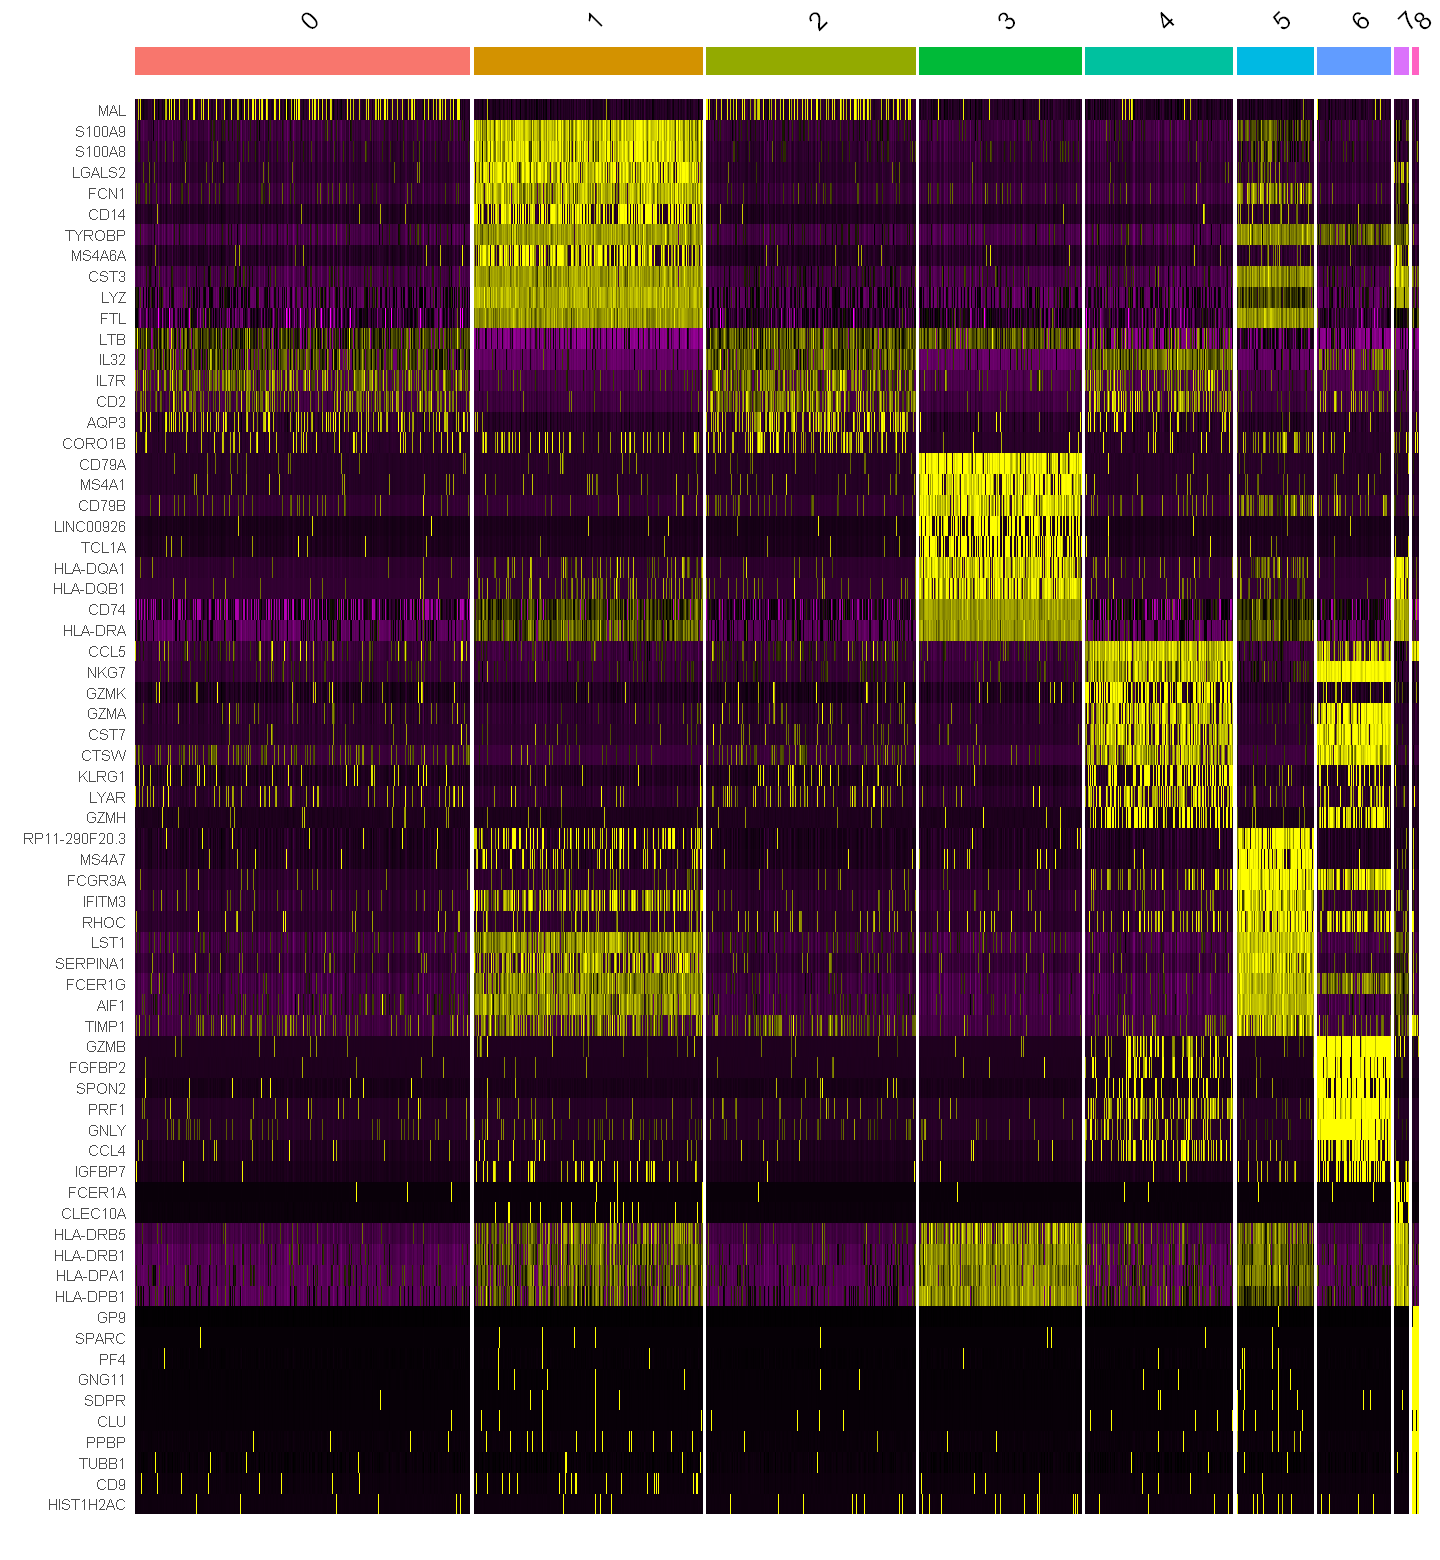

In [34]:
pbmc.markers %>%
    group_by(cluster) %>%
    top_n(n = 10, wt = avg_log2FC) -> top10
DoHeatmap(pbmc, features = top10$gene) + NoLegend()
options(repr.plot.height = 11, repr.plot.width = 20)

**Labelling**

Once we have the biological information we need, we can label our UMAP plot.

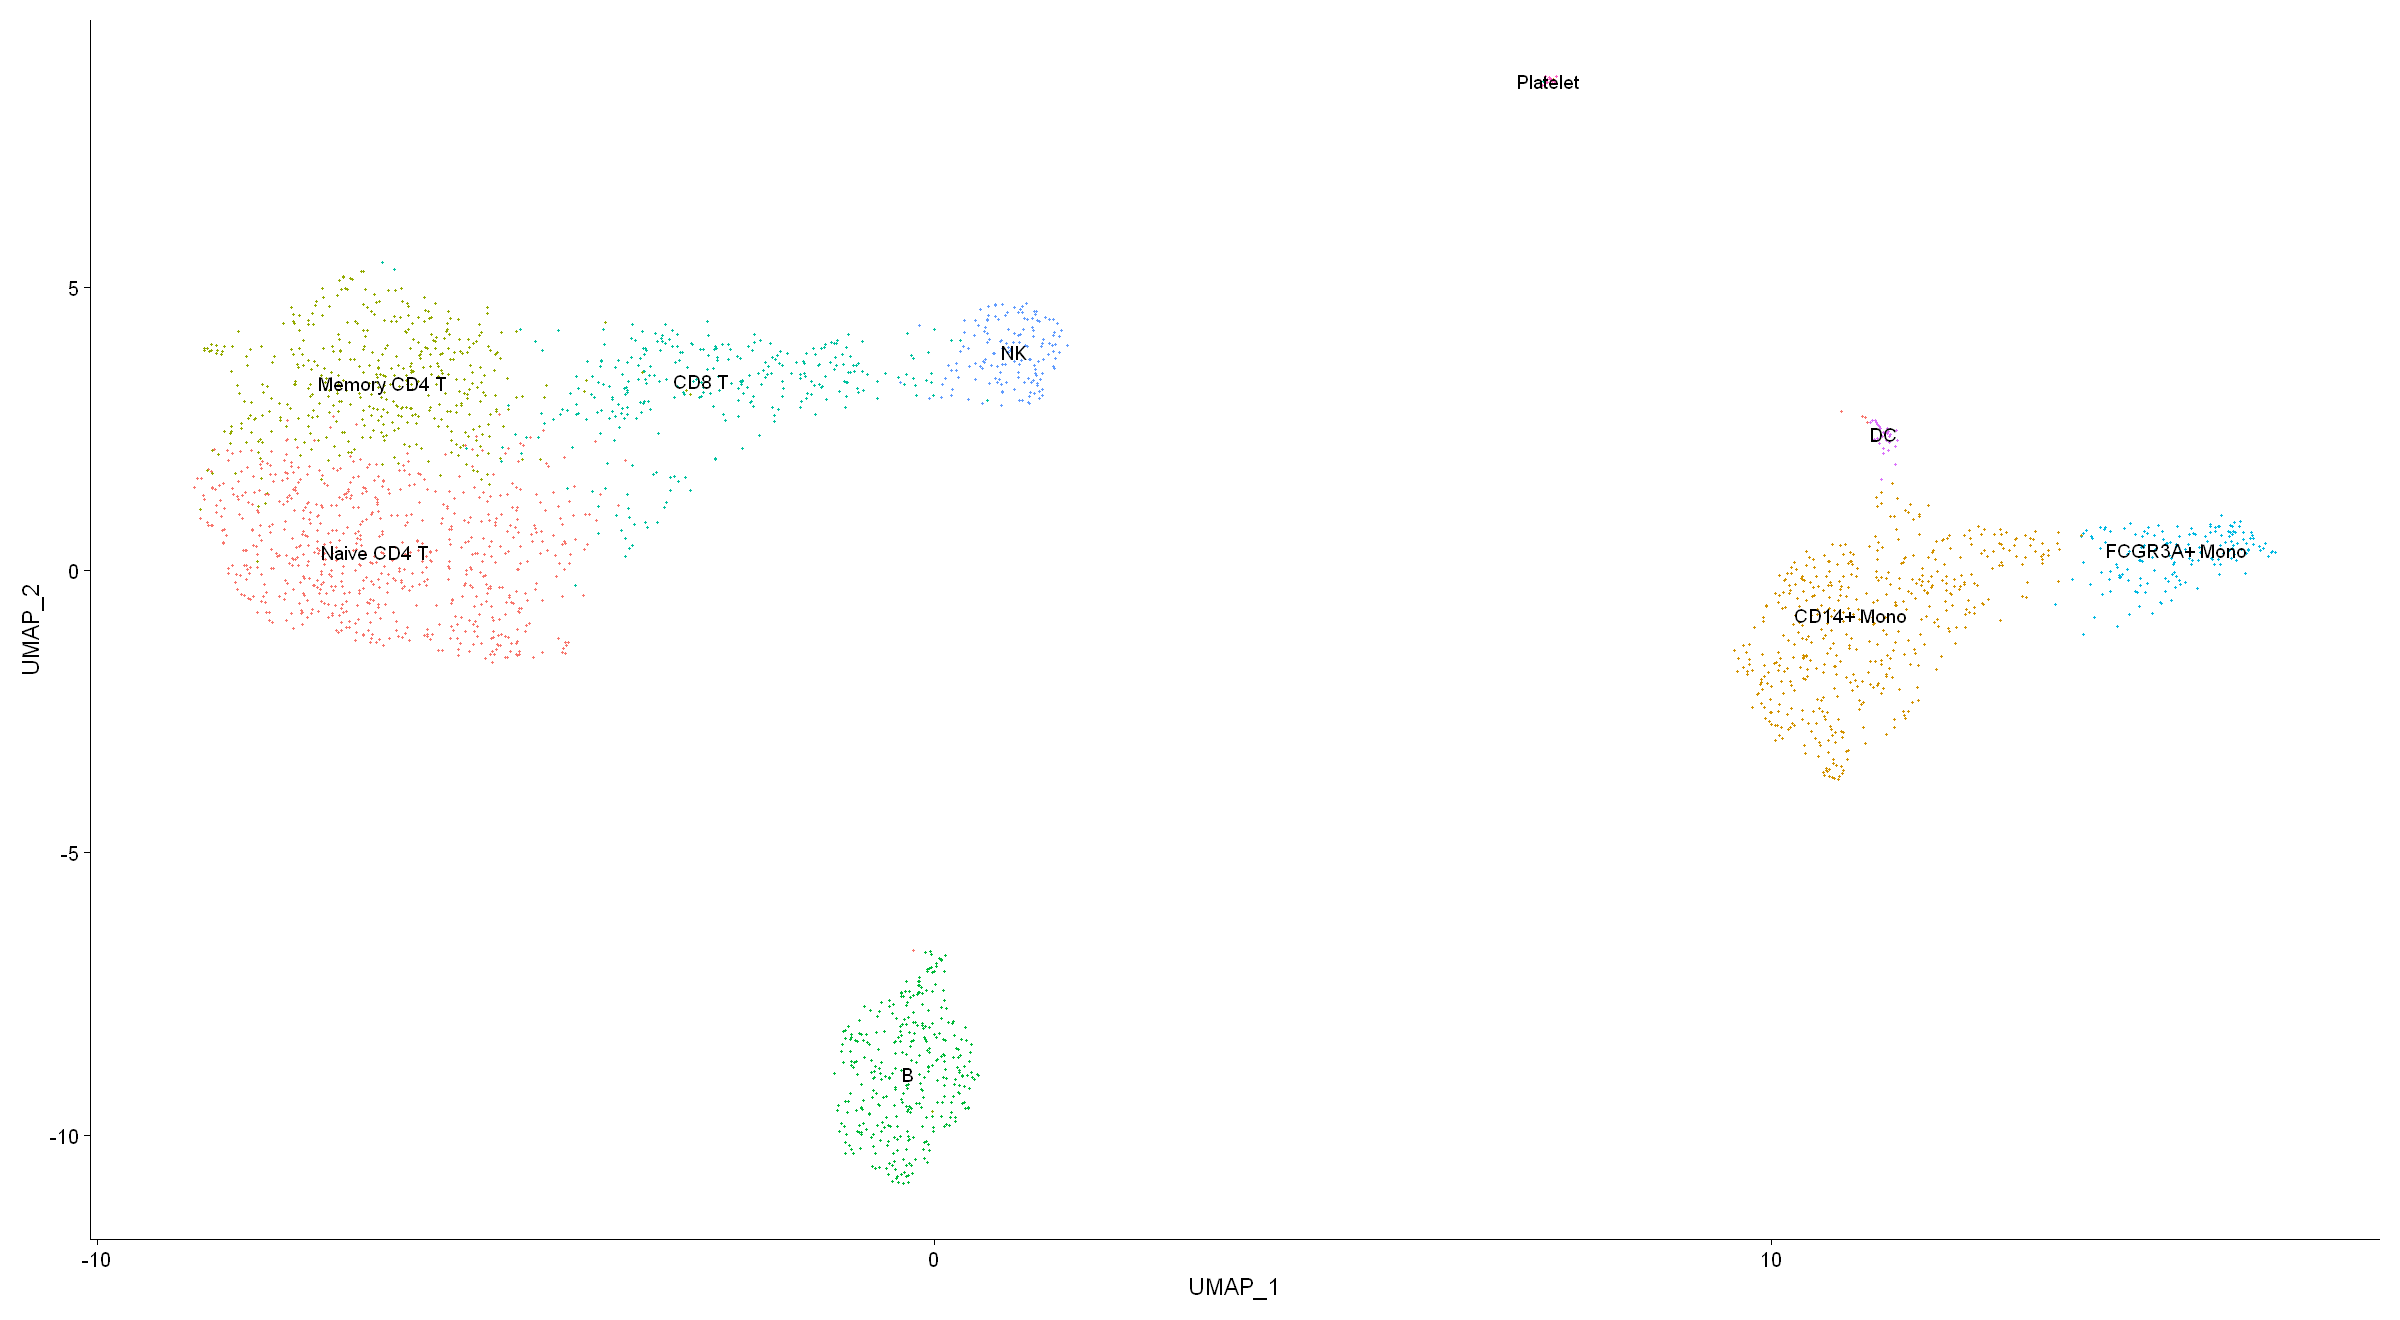

In [35]:
new.cluster.ids <- c("Naive CD4 T", "CD14+ Mono", "Memory CD4 T", "B", "CD8 T", "FCGR3A+ Mono",
    "NK", "DC", "Platelet")
names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

We can see the label we have given each cell using `Idents()`.

In [36]:
df <- as.data.frame(Idents(object = pbmc))
head(df)
write.csv(df, 'annotation.csv')

,Idents(object = pbmc)
,<fct>
AAACATACAACCAC-1,Naive CD4 T
AAACATTGAGCTAC-1,B
AAACATTGATCAGC-1,Memory CD4 T
AAACCGTGCTTCCG-1,CD14+ Mono
AAACCGTGTATGCG-1,NK
AAACGCACTGGTAC-1,Memory CD4 T


**Applying themes to plots**

Changing the visuals of our plots can make them easier to understand or highlight something of interest. Seurat plots using `ggplot2`, so plots can be manipulated in the same way as other `ggplot2` plots.

In [67]:
baseplot <- DimPlot(pbmc, reduction = "umap")

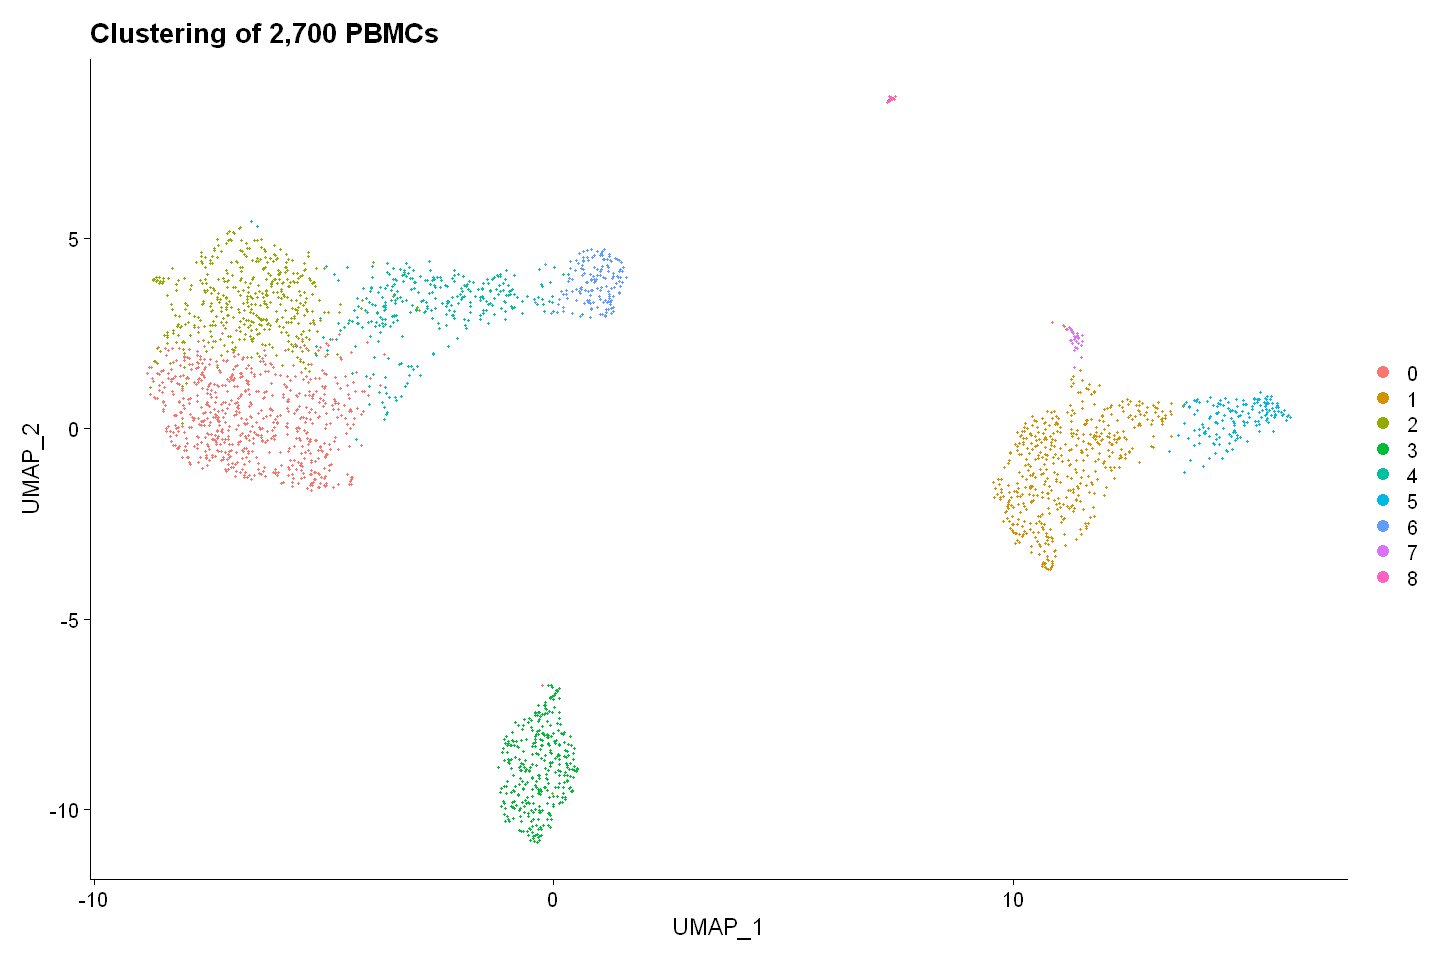

In [70]:
# Add labels

baseplot + labs(title = 'Clustering of 2,700 PBMCs')

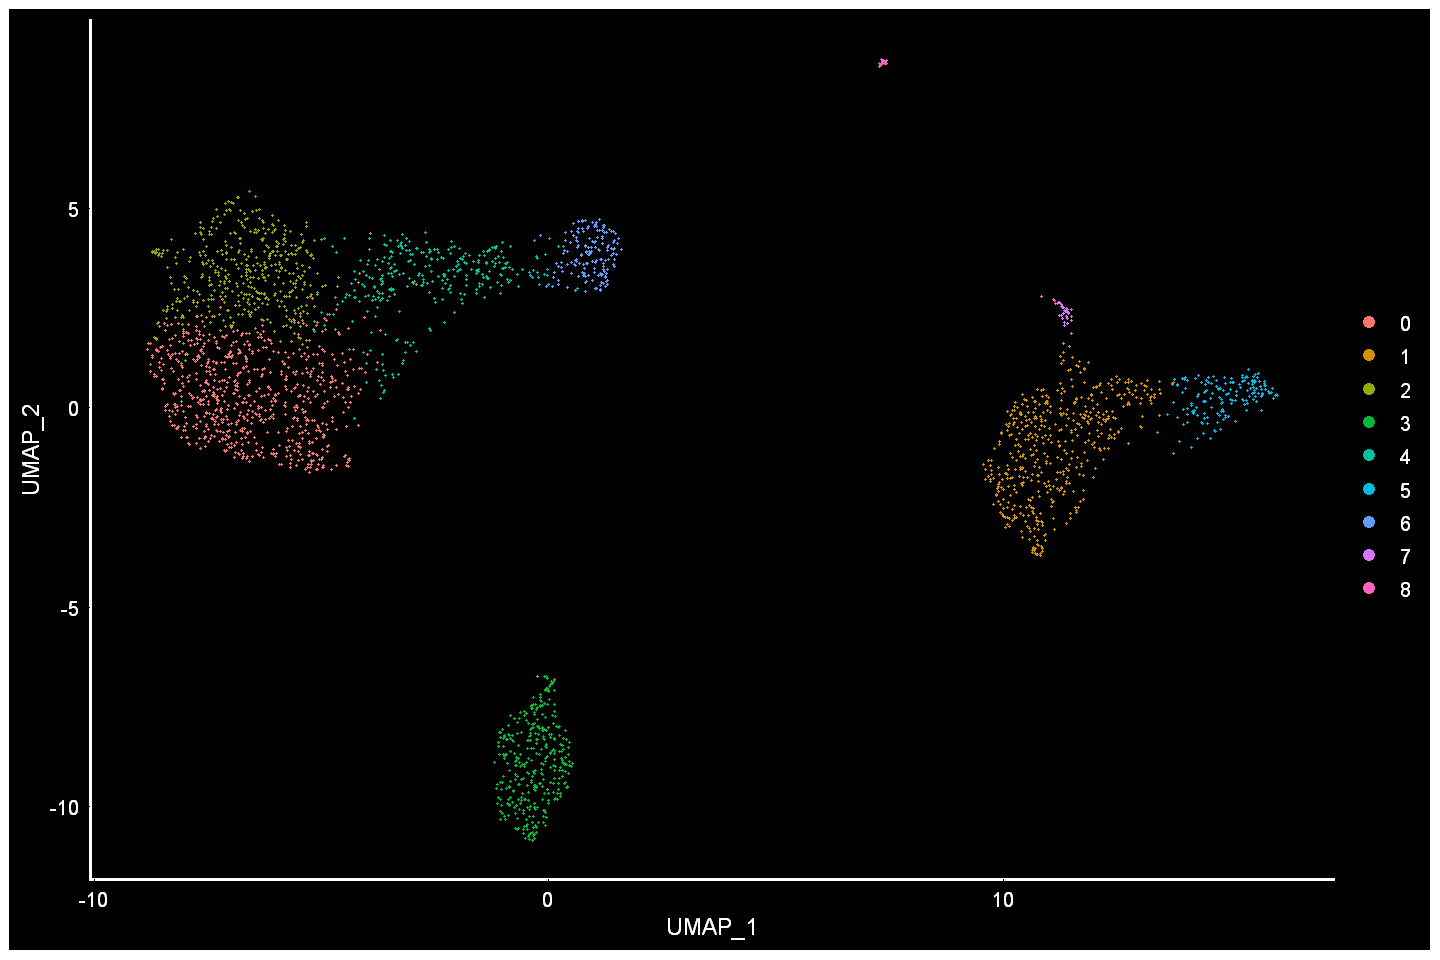

In [71]:
# Use built-in themes

baseplot + DarkTheme()

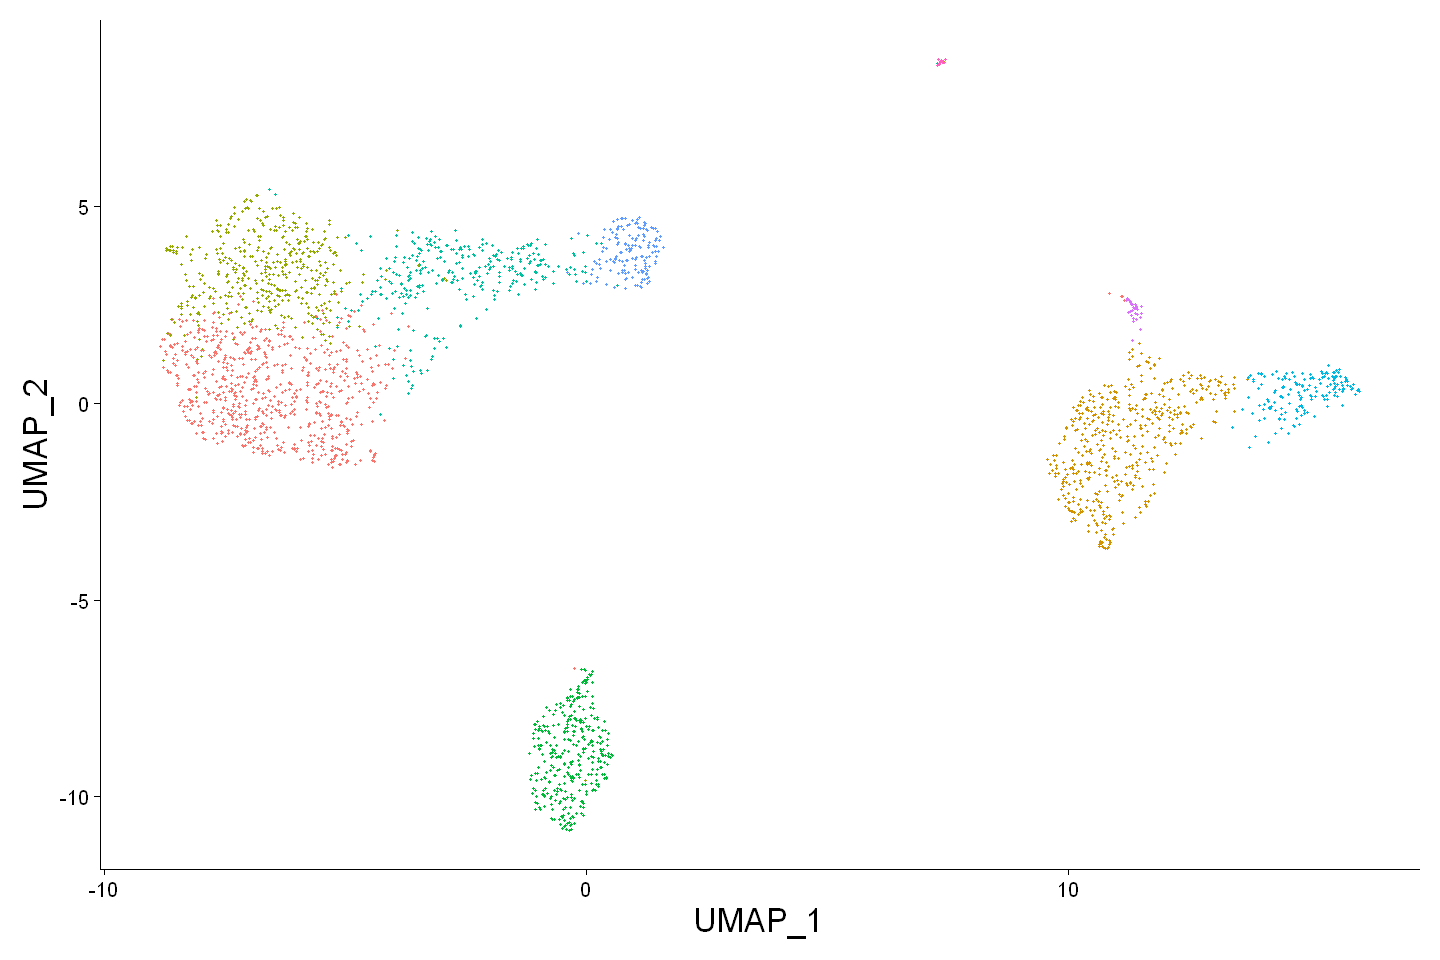

In [73]:
# You can chain themes together

baseplot + FontSize(x.title = 20, y.title = 20) + NoLegend()

You can save throughout the process using the `saveRDS()` function.

In [37]:
#saveRDS(pbmc, file = "../output/pbmc3k_final.rds")

https://satijalab.org/seurat/articles/de_vignette.html 

In [38]:
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 22000)

Matrix products: default

locale:
[1] LC_COLLATE=English_United Kingdom.1252 
[2] LC_CTYPE=English_United Kingdom.1252   
[3] LC_MONETARY=English_United Kingdom.1252
[4] LC_NUMERIC=C                           
[5] LC_TIME=English_United Kingdom.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] patchwork_1.1.2    sp_1.5-0           SeuratObject_4.1.2 Seurat_4.2.0      
[5] dplyr_1.0.10       repr_1.1.4        

loaded via a namespace (and not attached):
  [1] Rtsne_0.16            colorspace_2.0-3      deldir_1.0-6         
  [4] ellipsis_0.3.2        ggridges_0.5.4        IRdisplay_1.1        
  [7] base64enc_0.1-3       spatstat.data_2.2-0   farver_2.1.1         
 [10] leiden_0.4.3          listenv_0.8.0         ggrepel_0.9.1        
 [13] fansi_1.0.3           codetools_0.2-18      s